<a href="https://colab.research.google.com/github/kingwmoon/Algorithmic-Development-for-Reconstructing-Surface-Ocean-pCO2/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithmic Development for Reconstructing Surface Ocean pCO$_2$

Project3 Group2 - Pranav Gopal, Haoyue Wang, Ruoming Han, Jianing Fang

# Introduction

The ability to more accurately reconstruct air-sea CO2 exchange from time-dependent maps of surface ocean partial pressure of CO2 (pCO2) is extremely important to reducing uncertainty in the global carbon budget. Gloege et al (2021) used a Large Ensemble ESM Testbed to assess the reconstruction accuracy of an established SOM-FFN algorithm for *simulated pCO2 data*; Gloege et al (2022) used GOBM models as a prior combined with the XGBoost algorithm learn model-data mismatch and reconstruct *real world pCO2 data*. The starter code notebook combines the Ensemble ESM (CanESM2, r1r10 member) with the XGBoost algorithm to reconstruct pCO2 on unseen data within the simulated ESM Testbed to evaluate the effectiveness of this reconstruction approach. 

Our goal for this project was to test various deep learning architectures, to not only see if we could improve the overall accuracy of the pCO2 reconstruction on the simulated testbed (CanESM2, r1r10 member), but also to understand how these various deep learning architectures impact the effectiveness (MSE) of the pCO2 reconstruction in different global locations, as well as the different metrics (pCO2 mean bias and pCO2 mean correlation), and why these results are observed.

1.   The 13 features used for the XGBoost in the starter code are discrete features at particular time steps and locations but do not capture the spatial-temporal interactions. Using a time window of 6 months for the time series, we implemented an **RNN** to help understand the temporal component of each of the features, because the weight parameters are shared across time ensuring that memory is retained and it can learn from the past. 
2.   Treating the data as an image, we implemented a **CNN** to extract the spatial dependency in the predictor variables for predicting pCO2. The output vectors from the CNN using the AutoEncoder learns a lower dimensional embedding capturing the spatial dependency of the original features, and this embedding can be added as additional features for predicting the ocean pCO2 using the XGBoost.
3.   XGBoost is a non-parametric algorithm（we'll define the meaning of parametric and non-parametric in part III), and with the 13 features, our MSE is quite large. Non parametric algorithms suffer from the curse of dimensionality problem when analyzing high dimensional data, specifically the issue of data sparsity and “closeness” of data. However, **Semi-Parametric algorithms** (Projection Pursuit & Partial Linear) can simplify the model to help reduce the MSE and make the results more interpretable.

# Method 1: Explore the Potential of Using Temporal and Spatial Dependency to Better Reconstruct pCO2

**NOTICE TO READERS**: We processed the data and trained the network on the Ginsburg HPC cluster of Columbia University due to the memory constraint of the Colab Notebook using 16 CPU cores and 64GB of memory. The MSE of the baseline xgboost model (in the provided starter code) using default hyperparameters when running the model on the cluster is significantly less than the MSE when running the model on Colab. This disparity occurs most likely because xgboost can automatically select the maximum tree depth of the regressor based on the availability of memory (3 on Colab and 6 on the cluster). To make a fair comparison, we compared all our model performances with the baseline xgboost model on the same machine. It would not be possible to run the model directly on Colab due to memory constraints using the full dataset. You may need to upgrade to a paid Colab account to run the code. Alternatively, you can also load the model trained on the full dataset and test its performance on a subset of the dataset, but the performance metrics will differ from the reported values. We are sorry about the inconvenience. 

## Part I: Install python packages and set up workplace


In [ ]:
#@title Install packages from website
!pip install SkillMetrics
!pip install cmocean
!pip3 install cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely
!pip install projection-pursuit

     |████████████████████████████████| 63 kB 481 kB/s 
     |████████████████████████████████| 149 kB 9.6 MB/s 
     |████████████████████████████████| 223 kB 3.5 MB/s 
     |████████████████████████████████| 10.8 MB 4.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 26.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 26.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 40.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 44 kB 1.7 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516283 sha256=827a96465abda5ee9afb29a550ded826796c96

In [ ]:
# filter warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

#@title Import necessary packages
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import joblib
import pickle
import skill_metrics as sm

import seaborn as sns
import cmocean as cm            # really nice colorbars
import matplotlib.pyplot as plt # for making plots
from skpp import ProjectionPursuitRegressor
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import joblib
from pylab import mpl
from pandas import Series, DataFrame

# machine learning libraries
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import warnings
import torch
from torch import nn
from torch.utils.data import Dataset
import xgboost as xgb     # extreme gradient boosting (XGB
from xgboost import XGBRegressor

In [ ]:
#@title Connect colab to google drive
from google.colab import drive
drive.mount('/content/drive')
root_dir = "/content/drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project3_Group2/Final Folder/" # change it to your own project dir

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Set the work directory 
os.chdir(f"{root_dir}lib/") 
print(os.getcwd())
#/content/drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project 3/lib/

/content/drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project 3/lib


In [ ]:
#@title Load user python codes that contain user-created functions.
# Python file with supporting functions
import pre 
#import decompose as stl
from spatial_map import SpatialMap

## Part II: Reconstruction Preparation


In [ ]:
#@title Define reconstruction experiment parameters.
## define which ESM you will use, which member of the large ensemble, time range, and directories of the files
ens = 'CanESM2'
member = 'r1r10'

date_range_start = '1982-01-01T00:00:00.000000000'
date_range_end = '2017-01-31T00:00:00.000000000'

dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS') + np.timedelta64(14, 'D')

data_output_dir = f"{root_dir}/ESM/data/processed"
ensemble_dir_head = f"{root_dir}/ESM/" # Set this to where you have placed the raw data
xco2_path = f"{root_dir}/ESM/CESM001/member_001/XCO2_1D_mon_CESM001_native_198201-201701.nc" # xCO2(atmospheric CO2 mole fraction) is the same across members so only reference it once


reference_output_dir = f"{root_dir}/references"
model_output_dir = f"{root_dir}/models/trained"
recon_output_dir = f"{root_dir}/models/reconstructions"
other_output_dir = f"{root_dir}/models/performance_metrics"

approach = "xg"
approach2 = "ppm"
approach3 = "part_ln"
approach_output_dir = f"{other_output_dir}/{approach}"
approach2_output_dir = f"{other_output_dir}/{approach2}"
approach3_output_dir = f"{other_output_dir}/{approach3}"
param_fname = f"{approach_output_dir}/{approach}_best_params_dict.pickle"
param2_fname = f"{approach2_output_dir}/{approach2}_best_params_dict.pickle"
param3_fname = f"{approach3_output_dir}/{approach3}_best_params_dict.pickle"


In [ ]:
#@title Load and save ESM output
df = pre.create_inputs(ensemble_dir_head, ens, member, dates, xco2_path=xco2_path)
pre.save_clean_data(df, data_output_dir, ens, member)

# the data preprocess take 60 s

start to import member data
finish importing member data
start to create feature
Starting data saving process
Save complete


In [ ]:
#@title Set up for training the model
import sklearn            # machine-learning libary with many algorithms implemented
import xgboost as xgb     # extreme gradient boosting (XGB
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# =========================================
# Defining some inputs for the modeling process
# =========================================

# Train-validate-test split proportions
val_prop = .2
test_prop = .2

# Parameter grids
xg_param_grid = {"n_estimators":[2000, 3000, 4000],
                 "max_depth":[4,5,6]
                }

# Feature and target lists for feeding into the models
features_sel = ['sst_detrend', 'sst_anom', 'sss', 'sss_anom', 'mld_clim_log', 'chl_log', 'chl_anom', 'xco2', 'A', 'B', 'C', 'T0', 'T1']
target_sel = ['pCO2']

### prepare seen and unseen data.

"Seen" data are sampled from the ESM output at the locations where data exist in the real world. The database of pCO$_2$ data is the Surface Ocean CO$_2$ Atlas (SOCAT, https://www.socat.info).  

"Unseen" data are all the points that the reconstruction cannot learn from (in training, evaluation, or test). We are only able to compare to the unseen data within our ESM testbed. This capability is the fundamental motivation for the testbed.  

Our ultimate goal is to understand the uncertainties in a real world pCO$_2$ reconstruction. The testbed allows us to understand the strengths and weaknesses of any reconstruction approach. The strongest reconstruction approaches can then be used to reconstruct surface ocean pCO$_2$ for the real world using the actual SOCAT data (e.g. Bennington et al. 2022, in review for JAMES).

In [ ]:
#@title 
#Prepare the seen and unseen data. Split the trian and test data

data_dir = f"{data_output_dir}/{ens}/member_{member}"
fname = f"data_clean_2D_mon_{ens}_{member}_1x1_198201-201701.pkl"
file_path = f"{data_dir}/{fname}"
        
# Read in data, create some selection filters, produce a reduced dataframe
df = pd.read_pickle(file_path)

# 816 represents 3 standard deviations above mean in SOCAT data -- observations above this threshold are unrealistic to observe in real-world data
recon_sel = (~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)) & (df[target_sel] < 816).to_numpy().ravel()
sel = (recon_sel & (df['socat_mask'] == 1))
unseen_sel = (recon_sel & (df['socat_mask'] == 0))
        
 # Convert dataframe to numpy arrays, train/val/test split
X = df.loc[sel,features_sel].to_numpy()
y = df.loc[sel,target_sel].to_numpy().ravel()
                
N = X.shape[0]
train_val_idx, train_idx, val_idx, test_idx = pre.train_val_test_split(N, test_prop, val_prop)
X_train_val, X_train, X_val, X_test, y_train_val, y_train, y_val, y_test = pre.apply_splits(X, y, train_val_idx, train_idx, val_idx, test_idx) 

## Part III: Evaluate the performance of the baseline xgboost model for fair comparison

In [ ]:
#Train-validate-test split proportions
val_prop = .2
test_prop = .2

# Parameter grids
xg_param_grid = {"n_estimators":[2000, 3000, 4000],
                 "max_depth":[4,5,6]
                }

# Feature and target lists for feeding into the models
features_sel = ['sst_detrend', 'sst_anom', 'sss', 'sss_anom', 'mld_clim_log', 'chl_log', 'chl_anom', 'xco2', 'A', 'B', 'C', 'T0', 'T1']
target_sel = ['pCO2']

# 816 represents 3 standard deviations above mean in SOCAT data -- observations above this threshold are unrealistic to observe in real-world data
recon_sel = (~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)) & (df[target_sel] < 816).to_numpy().ravel()
sel = (recon_sel & (df['socat_mask'] == 1))
unseen_sel = (recon_sel & (df['socat_mask'] == 0))
        
 # Convert dataframe to numpy arrays, train/val/test split
X = df.loc[sel,features_sel].to_numpy()
y = df.loc[sel,target_sel].to_numpy().ravel()

N = X.shape[0]
train_val_idx, train_idx, val_idx, test_idx = pre.train_val_test_split(N, test_prop, val_prop)
X_train_val, X_train, X_val, X_test, y_train_val, y_train, y_val, y_test = pre.apply_splits(X, y, train_val_idx, train_idx, val_idx, test_idx) 
        
# Fit the model on train/validation data
# it take 17 seconds to train the model
model = XGBRegressor(n_jobs=1)
model.fit(X_train_val, y_train_val)          

# Save the model
pre.save_model(model, model_output_dir, approach, ens, member)

# Calculate some test error metrics and store in a dictionary
test_performance = defaultdict(dict)
y_pred_test = model.predict(X_test)
test_performance[ens][member] = pre.evaluate_test(y_test, y_pred_test)

# Redo this analysis on the unseen data
unseen_performance = defaultdict(dict)
y_pred_unseen = model.predict(df.loc[unseen_sel,features_sel].to_numpy())
y_unseen = df.loc[unseen_sel,target_sel].to_numpy().ravel()
unseen_performance[ens][member] = pre.evaluate_test(y_unseen, y_pred_unseen)

print("Baseline xgboost model test performance on Ginsburg cluster: ")
print(test_performance)
print("Baseline xgboost odel unseen performance on Ginsburg cluster: ")
print(unseen_performance)

del train_val_idx, train_idx, val_idx, test_idx, X_train_val, X_train, X_val, X_test, y_train_val, y_train, y_val, y_test

Starting model saving process
Save complete
Baseline xgboost model test performance on Ginsburg cluster: 
defaultdict(<class 'dict'>, {'CanESM2': {'r1r10': {'mse': 99.67275, 'mae': 6.582101, 'medae': 4.8927307, 'max_error': 260.26346, 'bias': -0.03668213, 'r2': 0.9352638618090201, 'corr': 0.96713923858011, 'cent_rmse': 9.983557613168916, 'stdev': 37.569736, 'amp_ratio': 0.88887256, 'stdev_ref': 39.23872, 'range_ref': 579.7588, 'iqr_ref': 50.934654235839844}}})
Baseline xgboost odel unseen performance on Ginsburg cluster: 
defaultdict(<class 'dict'>, {'CanESM2': {'r1r10': {'mse': 325.06485, 'mae': 10.300415, 'medae': 7.195404, 'max_error': 544.3163, 'bias': 0.77386475, 'r2': 0.7847717994645761, 'corr': 0.8861880589706765, 'cent_rmse': 18.01292902280759, 'stdev': 34.932484, 'amp_ratio': 0.8692974, 'stdev_ref': 38.86292, 'range_ref': 694.08203, 'iqr_ref': 47.25750732421875}}})


## Part IV: Use RNN to encode recent temporal information

We used a recurrent neural network (RNN) to explore the potential “memory effect” of physical drivers on the ocean pCO2 level. If there is a significant time lag between the driving processes and the and ocean pCO2 level, using the recent time series of driver variables should improve the prediction accuracy of the pCO2. By contrast, if the pCO2 responds rapidly to its physical drivers, we will observe little time lag between the physical drivers and pCO2, and thus little improvement in prediction even if the recent time series of driver variables are used as input. 

We implemented an RNN with a hidden dimension of 32, followed by a feedforward network of 5 hidden layers each with 64 neurons (see figure below). We initially used the 12 months of 13-physical variables up to the time each pCO2 as an input to the recurrent neural network, but the network was very difficult to train and did not converge properly, which might be a result of vanishing gradient given the rather long sequence. We then used only 6-months of physical variables and were able to achieve much better prediction results. We used 80-20% split of the seen data for training and validation to find the best epoch for early stopping, and then retrain the entire network with seen data up to the early stopping epoch to avoid overfitting. We then test the network on unseen data to compare with the baseline xgboost model.


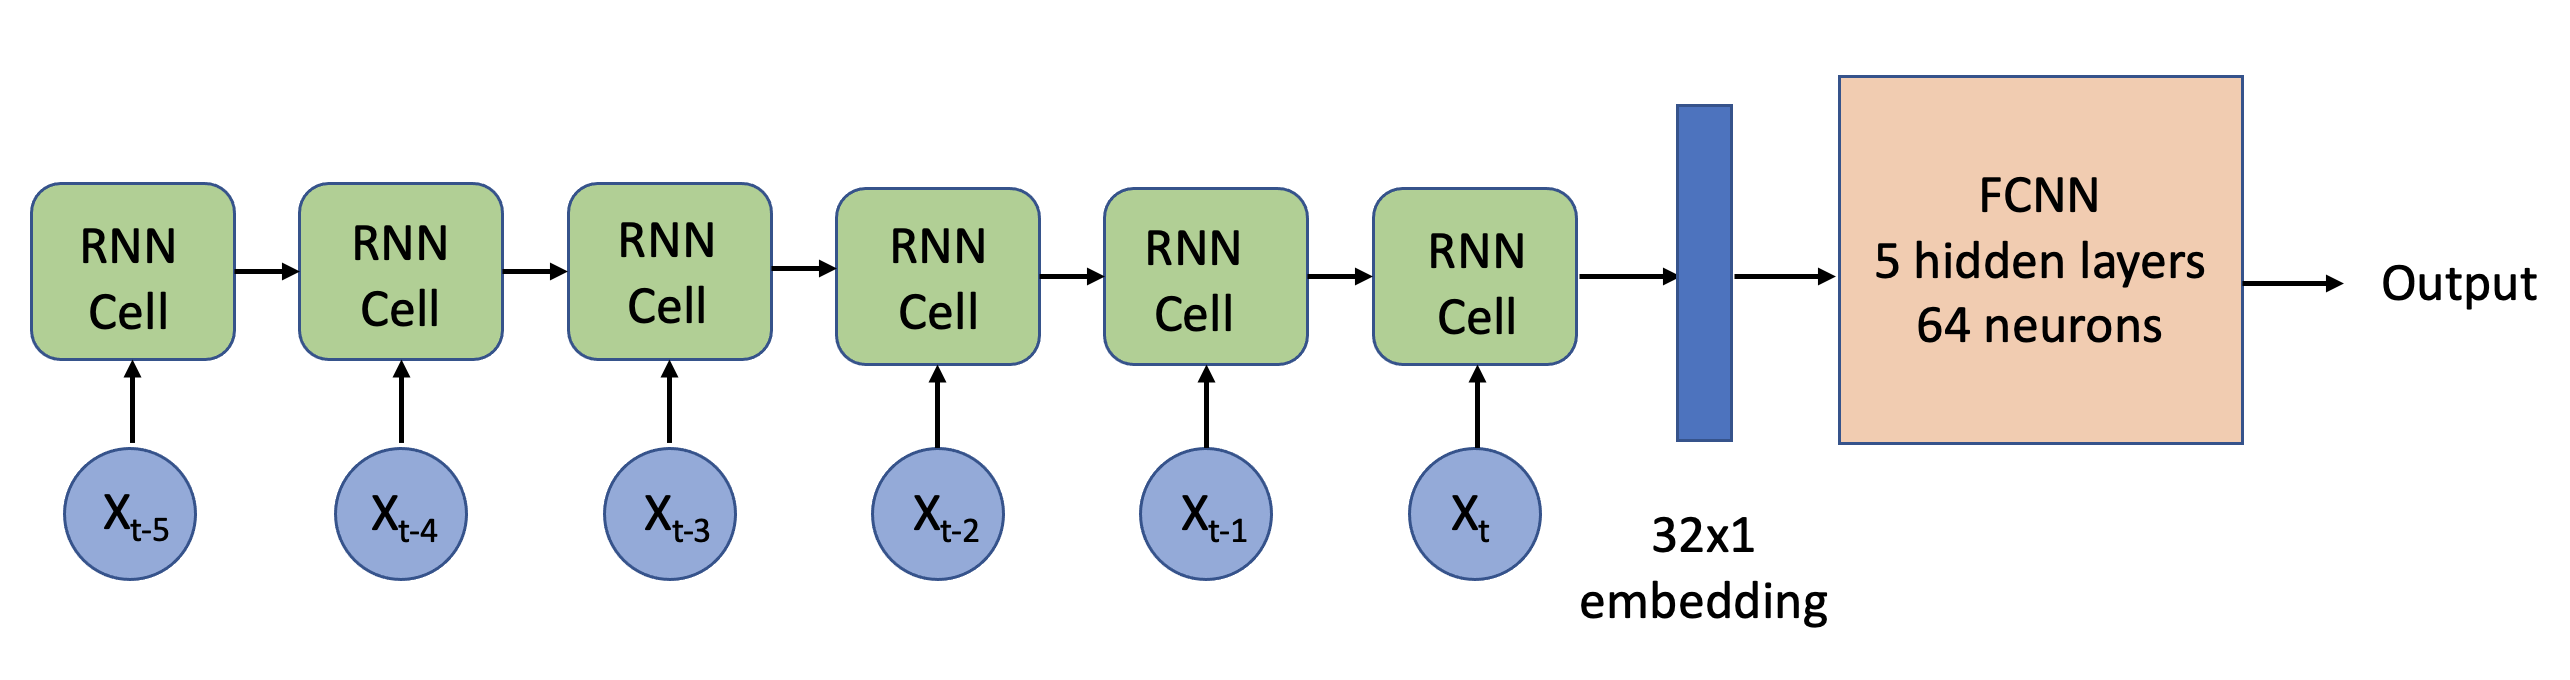

#### Define and train the rnn network

In [ ]:
"""
    generate normalized datasets for recurrent neural network training.
    
    Arguments:
        - df: pandas dataframe containining all the variables, generated using pre.create_inputs()
        - features_sel: a list of variable names to be used as features for the rnn
        - target_sel: a single element list of variable name for the target 
        - months_back: the number of months including and before the current month for training.
    Outputs:
        - rnn_x: a numpy array containing training normalized features
        - rnn_y: a numpy array containing training targets
        - test_rnn_x: a numpy array containing test features, normalized
        - test_rnn_y, a numpy array containing test outputs.
        - scaler: fitted standardized scaler that can be later used.

"""
def generate_normalized_datasets_for_rnn(df, features_sel, target_sel=['pCO2'], months_back=6):
    # select unmasked datasets with all observations available and unrealistic modeled pCO2 removed
    recon_sel = (~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)) & (df[target_sel] < 816).to_numpy().ravel()
    # select datapoints where socat observations are available for training and validation
    sel = (recon_sel & (df['socat_mask'] == 1))
    # select datapoints where socat observations are not available for testing purposes.
    unseen_sel = (recon_sel & (df['socat_mask'] == 0))
    
    idx=np.arange(len(sel))[sel.to_numpy()]
    
    # index of current and past records
    sel_history=np.array([[i - j * 180 * 360 for j in range(months_back)] for i in idx])
    
    # remove index before the first available date
    sel_history=sel_history[(sel_history>0).all(axis=1)]
    X=df[features_sel].to_numpy()
    
    # normalize the dataset 
    scaler = preprocessing.StandardScaler().fit(X) 
    X=scaler.transform(X)
    
    rnn_x=X[sel_history]
    rnn_y=df[target_sel].to_numpy()[sel_history[:, 0]]
    
    unseen_idx=np.arange(len(unseen_sel))[unseen_sel.to_numpy()]
    unseen_sel_history=np.array([[i - j * 180 * 360 for j in range(months_back)] for i in unseen_idx])
    unseen_sel_history=unseen_sel_history[(unseen_sel_history>0).all(axis=1)]
    
    test_rnn_x=X[unseen_sel_history]
    test_rnn_y=df[target_sel].to_numpy()[unseen_sel_history[:, 0]]
    
    return rnn_x, rnn_y, test_rnn_x, test_rnn_y, scaler


# a class for rnn dataset
class RNNDataset(Dataset):
    def __init__(self, x, y):
        self.x=torch.tensor(x).float()
        self.y=torch.tensor(y).float()
        
    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
features_sel = ['sst_detrend', 'sst_anom', 'sss', 'sss_anom', 'mld_clim_log', 'chl_log', 'chl_anom', 'xco2', 'A', 'B', 'C', 'T0', 'T1']
target_sel = ['pCO2']

rnn_x, rnn_y, test_rnn_x, test_rnn_y, scaler=generate_normalized_datasets_for_rnn(df, features_sel, target_sel=['pCO2'], months_back=6)
    
batch_size=32

# using 80% of the seen data for training and 20% for validation
train_val_split=0.8

train_index=int(rnn_x.shape[0] * train_val_split)
all_dataset=RNNDataset(rnn_x, rnn_y)
train_dataset=RNNDataset(rnn_x[0:train_index], rnn_y[0:train_index])
val_dataset=RNNDataset(rnn_x[train_index:], rnn_y[train_index:])
test_dataset=RNNDataset(test_rnn_x, test_rnn_y)

# create the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
all_loader = torch.utils.data.DataLoader(all_dataset, batch_size=batch_size, shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class RNNnet(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.5):
        super(RNNnet, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_size = input_dim, 
                            hidden_size = hidden_dim, 
                            num_layers = 1, 
                            batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_dim, 64), nn.ReLU(), nn.Dropout(dropout),
                                nn.Linear(64, 64), nn.ReLU(), nn.Dropout(dropout),
                                nn.Linear(64, 64), nn.ReLU(), nn.Dropout(dropout),
                                nn.Linear(64, 64), nn.ReLU(), nn.Dropout(dropout),
                                nn.Linear(64, 64), nn.ReLU(), nn.Dropout(dropout),
                                nn.Linear(64, 1), nn.ReLU())
        
    def forward(self, x):
        out, hidden = self.rnn(x)
        return self.fc(hidden.squeeze())

In [ ]:
### Training function
def rnn_train_epoch(net, device, dataloader, loss_fn, optimizer, batch_size=32):
    # Set train mode
    net.train()
    train_loss = 0
    total_number = len(dataloader)
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, y in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        target = y.to(device)
        output = net(x)
        # Evaluate loss
        loss = loss_fn(target, output)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        train_loss = train_loss + loss.detach().cpu().numpy().item()
    return train_loss/total_number/batch_size

### Testing function
def rnn_test_epoch(net, device, dataloader, loss_fn, batch_size=32):
    val_loss=0
    total_number = len(dataloader)
    with torch.no_grad(): # No need to track the gradients
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            target = y.to(device)
            output = net(x)
            # Evaluate loss
            loss = loss_fn(target, output)
            val_loss = val_loss + loss.detach().cpu().numpy().item()
    return val_loss/total_number/batch_size

### Testing function on unseen data, return the output
def rnn_unseen_test(net, device, dataloader, loss_fn, batch_size=32):
    val_loss=0
    total_number = len(dataloader)
    output_list=[]
    with torch.no_grad(): # No need to track the gradients
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            target = y.to(device)
            output = rnn_net(x).flatten().numpy()
            output_list.append(output)
    return np.concatenate(output_list)

In [ ]:
input_dim = len(features_sel)
hidden_dim = 32
rnn_net = RNNnet(input_dim, hidden_dim, dropout=0)
loss_fn = nn.MSELoss(reduction='sum')
learning_rate=1e-4
optimizer = torch.optim.Adam(rnn_net.parameters(), lr=learning_rate)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
rnn_net.to(device)

Selected device: cpu


RNNnet(
  (rnn): RNN(13, 32, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0, inplace=False)
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0, inplace=False)
    (12): Linear(in_features=64, out_features=64, bias=True)
    (13): ReLU()
    (14): Dropout(p=0, inplace=False)
    (15): Linear(in_features=64, out_features=1, bias=True)
    (16): ReLU()
  )
)

In [ ]:
# find the best early stoping epoch by finding the best 
# achivable loss on validation dataset with patience of 10 epoches

num_epochs = 200
diz_loss = {'train_loss':[],'val_loss':[]}
best_val_loss=1e9
no_improvement=0
patience=10
best_epoch=0
for epoch in range(num_epochs):
    train_loss =rnn_train_epoch(rnn_net,device,train_loader,loss_fn,optimizer)
    val_loss = rnn_test_epoch(rnn_net,device,val_loader,loss_fn)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss, val_loss))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
    if val_loss < best_val_loss:
        best_val_loss=val_loss
        no_improvement=0
    else:
        no_improvement=no_improvement + 1
    if no_improvement > patience:
        print("Early stopping epoch: {}".format(epoch+1))
        best_epoch=epoch
        break


 EPOCH 1/200 	 train loss 7850.636 	 val loss 730.596

 EPOCH 2/200 	 train loss 647.570 	 val loss 595.553

 EPOCH 3/200 	 train loss 547.125 	 val loss 484.761

 EPOCH 4/200 	 train loss 462.990 	 val loss 412.012

 EPOCH 5/200 	 train loss 408.647 	 val loss 391.521

 EPOCH 6/200 	 train loss 379.715 	 val loss 372.861

 EPOCH 7/200 	 train loss 358.295 	 val loss 365.112

 EPOCH 8/200 	 train loss 341.625 	 val loss 345.745

 EPOCH 9/200 	 train loss 327.535 	 val loss 328.073

 EPOCH 10/200 	 train loss 314.344 	 val loss 343.140

 EPOCH 11/200 	 train loss 303.376 	 val loss 317.662

 EPOCH 12/200 	 train loss 293.212 	 val loss 320.586

 EPOCH 13/200 	 train loss 284.899 	 val loss 295.367

 EPOCH 14/200 	 train loss 276.806 	 val loss 296.785

 EPOCH 15/200 	 train loss 269.038 	 val loss 281.330

 EPOCH 16/200 	 train loss 263.010 	 val loss 276.295

 EPOCH 17/200 	 train loss 257.787 	 val loss 295.491

 EPOCH 18/200 	 train loss 251.964 	 val loss 283.449

 EPOCH 19/200 	 t

In [ ]:
# redefine the network for retraining using all seen data
input_dim = len(features_sel)
hidden_dim = 32
rnn_net = RNNnet(input_dim, hidden_dim, dropout=0)
loss_fn = nn.MSELoss(reduction='sum')
learning_rate=1e-4
optimizer = torch.optim.Adam(rnn_net.parameters(), lr=learning_rate)
# Move both the encoder and the decoder to the selected device
rnn_net.to(device)

Selected device: cpu


RNNnet(
  (rnn): RNN(13, 32, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0, inplace=False)
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0, inplace=False)
    (12): Linear(in_features=64, out_features=64, bias=True)
    (13): ReLU()
    (14): Dropout(p=0, inplace=False)
    (15): Linear(in_features=64, out_features=1, bias=True)
    (16): ReLU()
  )
)

In [ ]:
# retrain the network on all seen data 
num_epochs = best_epoch
diz_loss = {'train_loss':[]}
best_val_loss=1e9
no_improvement=0
patience=10
for epoch in range(num_epochs):
    train_loss =rnn_train_epoch(rnn_net,device,all_loader,loss_fn,optimizer)
    print('\n EPOCH {}/{} \t train loss {:.3f}'.format(epoch + 1, num_epochs,train_loss))
    diz_loss['train_loss'].append(train_loss)


 EPOCH 1/161 	 train loss 6166.652

 EPOCH 2/161 	 train loss 550.056

 EPOCH 3/161 	 train loss 475.137

 EPOCH 4/161 	 train loss 430.145

 EPOCH 5/161 	 train loss 401.709

 EPOCH 6/161 	 train loss 376.857

 EPOCH 7/161 	 train loss 350.806

 EPOCH 8/161 	 train loss 324.747

 EPOCH 9/161 	 train loss 302.675

 EPOCH 10/161 	 train loss 283.659

 EPOCH 11/161 	 train loss 269.931

 EPOCH 12/161 	 train loss 257.730

 EPOCH 13/161 	 train loss 249.218

 EPOCH 14/161 	 train loss 241.828

 EPOCH 15/161 	 train loss 235.114

 EPOCH 16/161 	 train loss 229.999

 EPOCH 17/161 	 train loss 225.161

 EPOCH 18/161 	 train loss 222.186

 EPOCH 19/161 	 train loss 218.600

 EPOCH 20/161 	 train loss 215.386

 EPOCH 21/161 	 train loss 212.148

 EPOCH 22/161 	 train loss 209.634

 EPOCH 23/161 	 train loss 207.103

 EPOCH 24/161 	 train loss 204.493

 EPOCH 25/161 	 train loss 202.186

 EPOCH 26/161 	 train loss 200.243

 EPOCH 27/161 	 train loss 197.929

 EPOCH 28/161 	 train loss 195.617


In [ ]:
# save the model
torch.save(rnn_net.state_dict(), f"{root_dir}/models/trained/rnn_save.pickle")

#### Apply the rnn network on unseen dataset

In [ ]:
rnn_net = RNNnet(input_dim, hidden_dim, dropout=0)
rnn_net.load_state_dict(torch.load(f"{root_dir}/models/trained/rnn_save.pickle"))
rnn_net.eval();

In [ ]:
# evaluate the data on unseen dataset
rnn_net.eval()
rnn_unseen_output=rnn_unseen_test(rnn_net, device, test_loader, loss_fn)

In [ ]:
def evaluate_test(y, pred):
    scores = {
        'mse':pre.mean_squared_error(y, pred),
        'mae':pre.mean_absolute_error(y, pred),
        'medae':pre.median_absolute_error(y, pred),
        'max_error':pre.max_error(y, pred),
        'bias':pred.mean() - y.mean(),
        'r2':pre.r2_score(y, pred),
        'cent_rmse':pre.centered_rmse(y,pred),
        'stdev' :np.std(pred),
        'amp_ratio':(np.max(pred)-np.min(pred))/(np.max(y)-np.min(y)), # added when doing temporal decomposition
        'stdev_ref':np.std(y),
        'range_ref':np.max(y)-np.min(y),
        'iqr_ref':np.subtract(*np.percentile(y, [75, 25]))
        }
    return scores

In [ ]:
print("Test statistics of rnn network on unseen datasets")
print(evaluate_test(test_rnn_y, rnn_unseen_output.reshape(-1, 1)))

Test statistics of rnn network on unseen datasets
{'mse': 336.6129, 'mae': 10.479534, 'medae': 7.215393, 'max_error': 543.01385, 'bias': -0.7720947, 'r2': 0.7759732974788542, 'cent_rmse': 18.33075739030476, 'stdev': 35.934338, 'amp_ratio': 0.98780125, 'stdev_ref': 38.76283, 'range_ref': 694.08203, 'iqr_ref': 47.1009521484375}


## Part V: Learning spatial patterns in ocean SST with CNN-autoencoder as embeddings for global ocean state

We implemented convolutional autoencoder to learn embeddings for the main modes of variabilities in sea surface temperature (SST). Unlike the original input features are locally simulated outputs of the ESM, this embedding is learned from the global spatial pattern of SST distribution and is expected to capture variations in SST teleconnections such as the El-Nino Southern Oscillation.    
  

In this study, the simulated SST from an ESM member is used to test the capacity of the autoencoder within the large ensemble testbed, whereas  satellite-observed monthly SST datasets can be used in a production environment for predicting actual pCO2. To uncover the signal for modes of variabilities, we removed the long-term trend and seasonal cycle in the SST timeseries. Continental and coastal regions without valid observations are assigned the dummy value 0 to prevent the propagation of NaNs in the network but are masked out in the loss function so that only valid input locations are learned by the network. A 360x180 tensor containing each month’s data is first passed into an encoder network (Figure 1). The encoder network consists of five convolutional layers with a kernel size of 5 pixels, and paddings are added to each layer so that the dimensions of the next layer are one-half of the previous layer. The sequence of convolution layers allows us to learn increasingly abstract spatial features with a comparatively small number of parameters by leveraging the translational invariance of convolution operations. RELU activation function and batch normalization are added between the layers to learn non-linear relationships while maintaining model stability. The output of the final layer is flattened and mapped with a dense network to an embedding output with length 3.




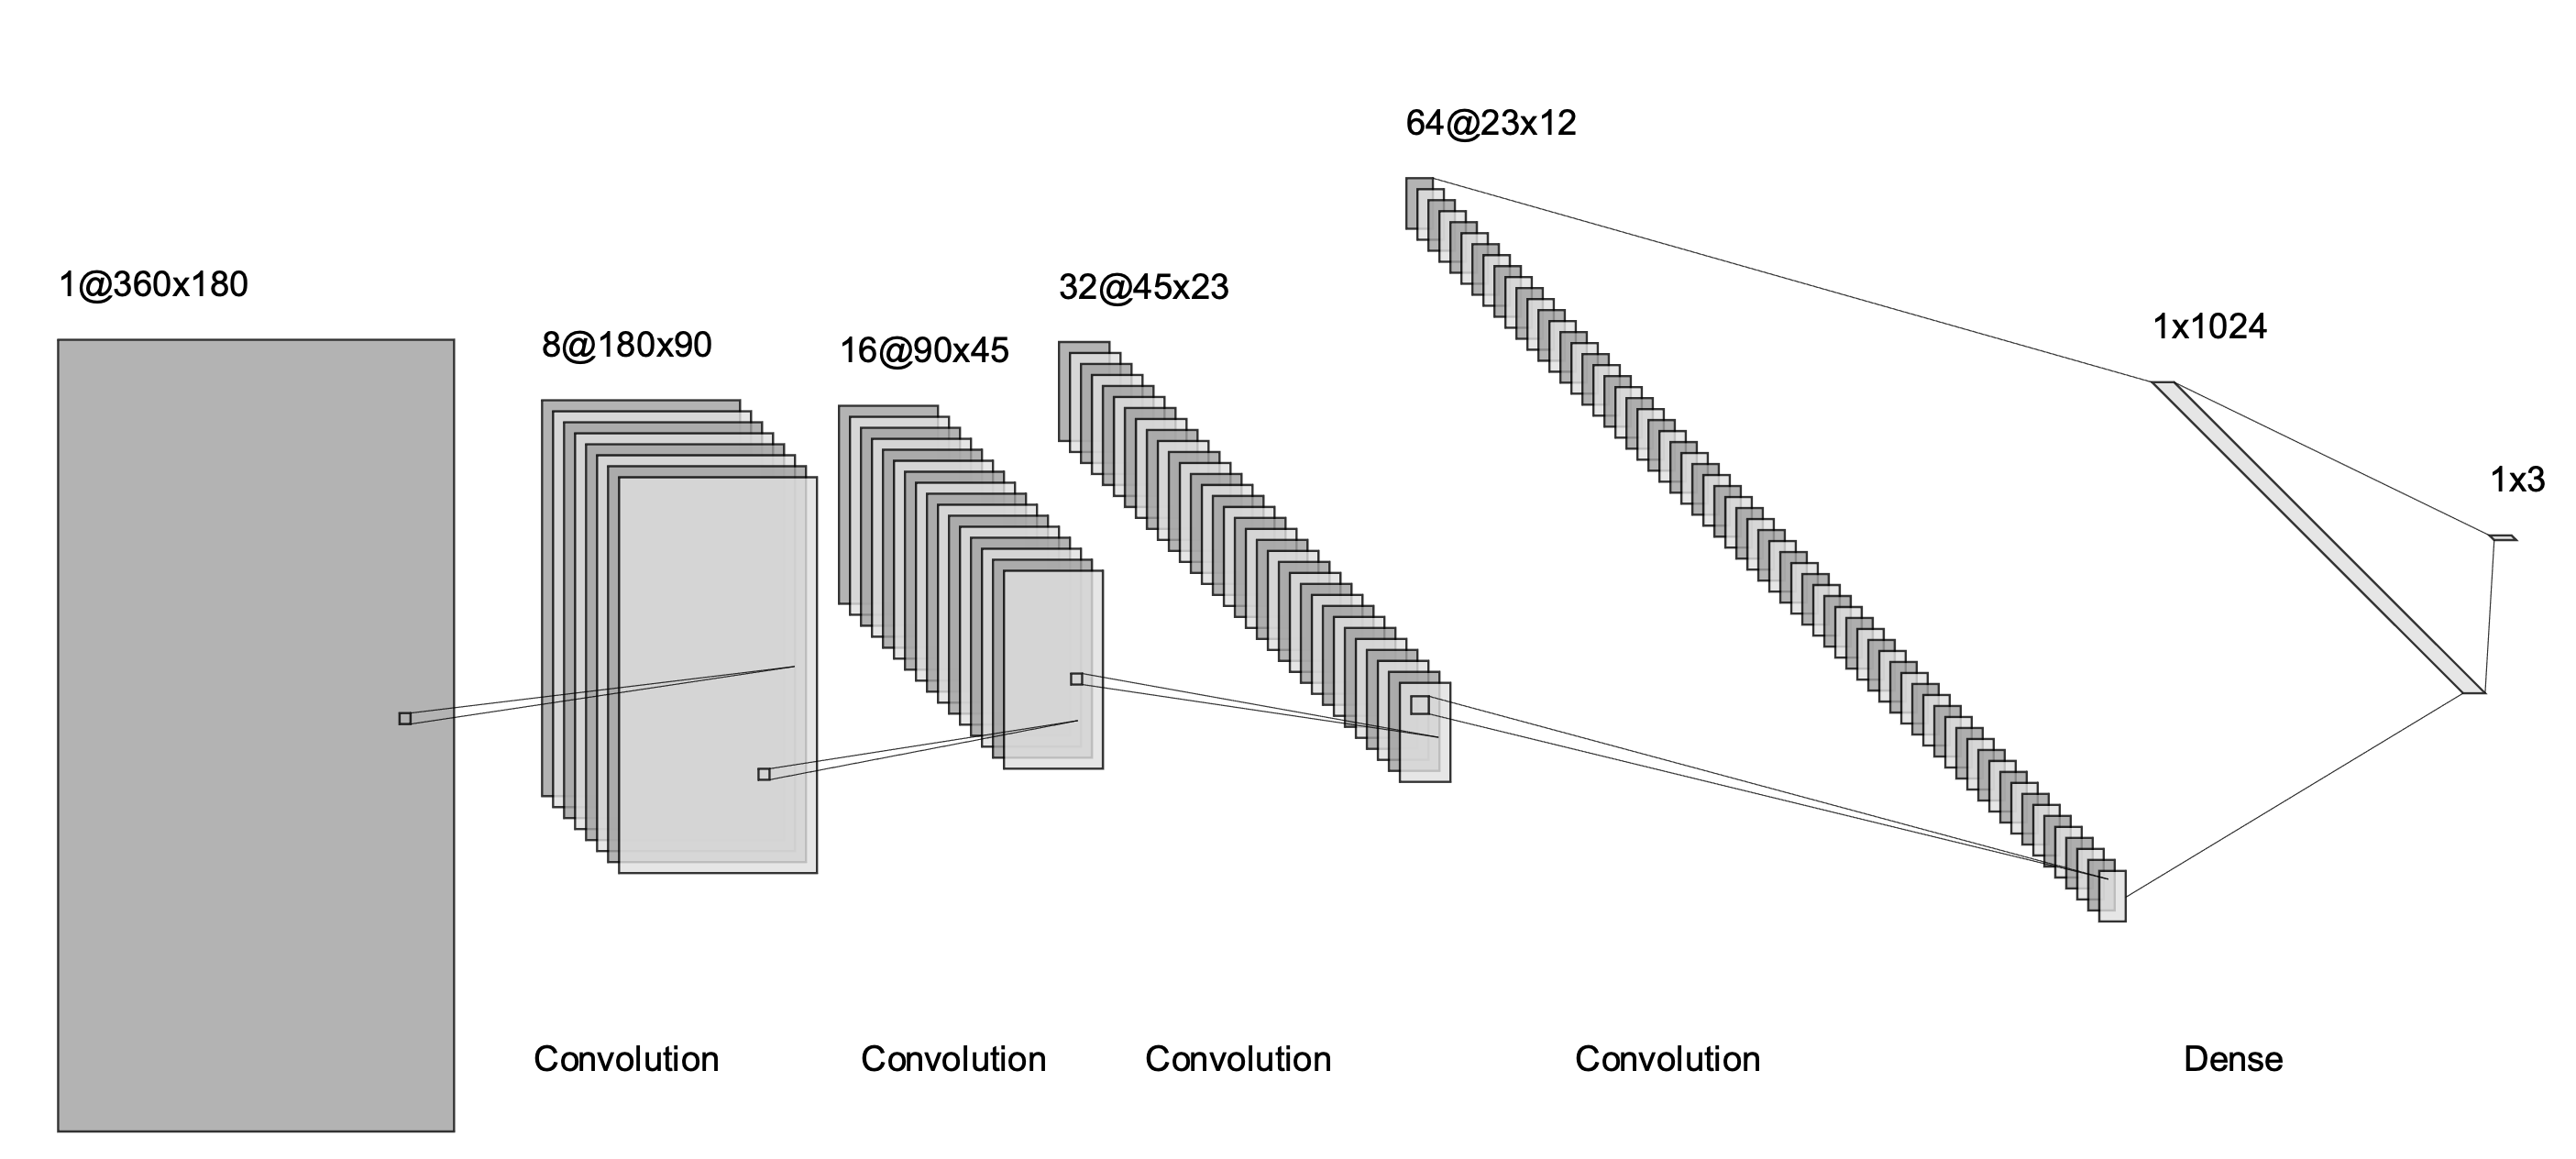  

**Figure 1**. Detailed view of the encoder network



During training, the encoder is coupled with a decoder network which has a reverse structure to the encoder that maps from the 3-entry embedding to an output tensor with the same dimension as the output tensor (Figure 2). The loss function is defined as the MSE distance between the output and the original input tensor. By training the encoder and decoder at once, we are essentially solving a non-linear dimensionality reduction problem to capture as many of the variations in the input tensor with the 3-entry embedding.  This implementation is inspired by the blog post: https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac. The diagram is created with the tool: http://alexlenail.me/NN-SVG/LeNet.html


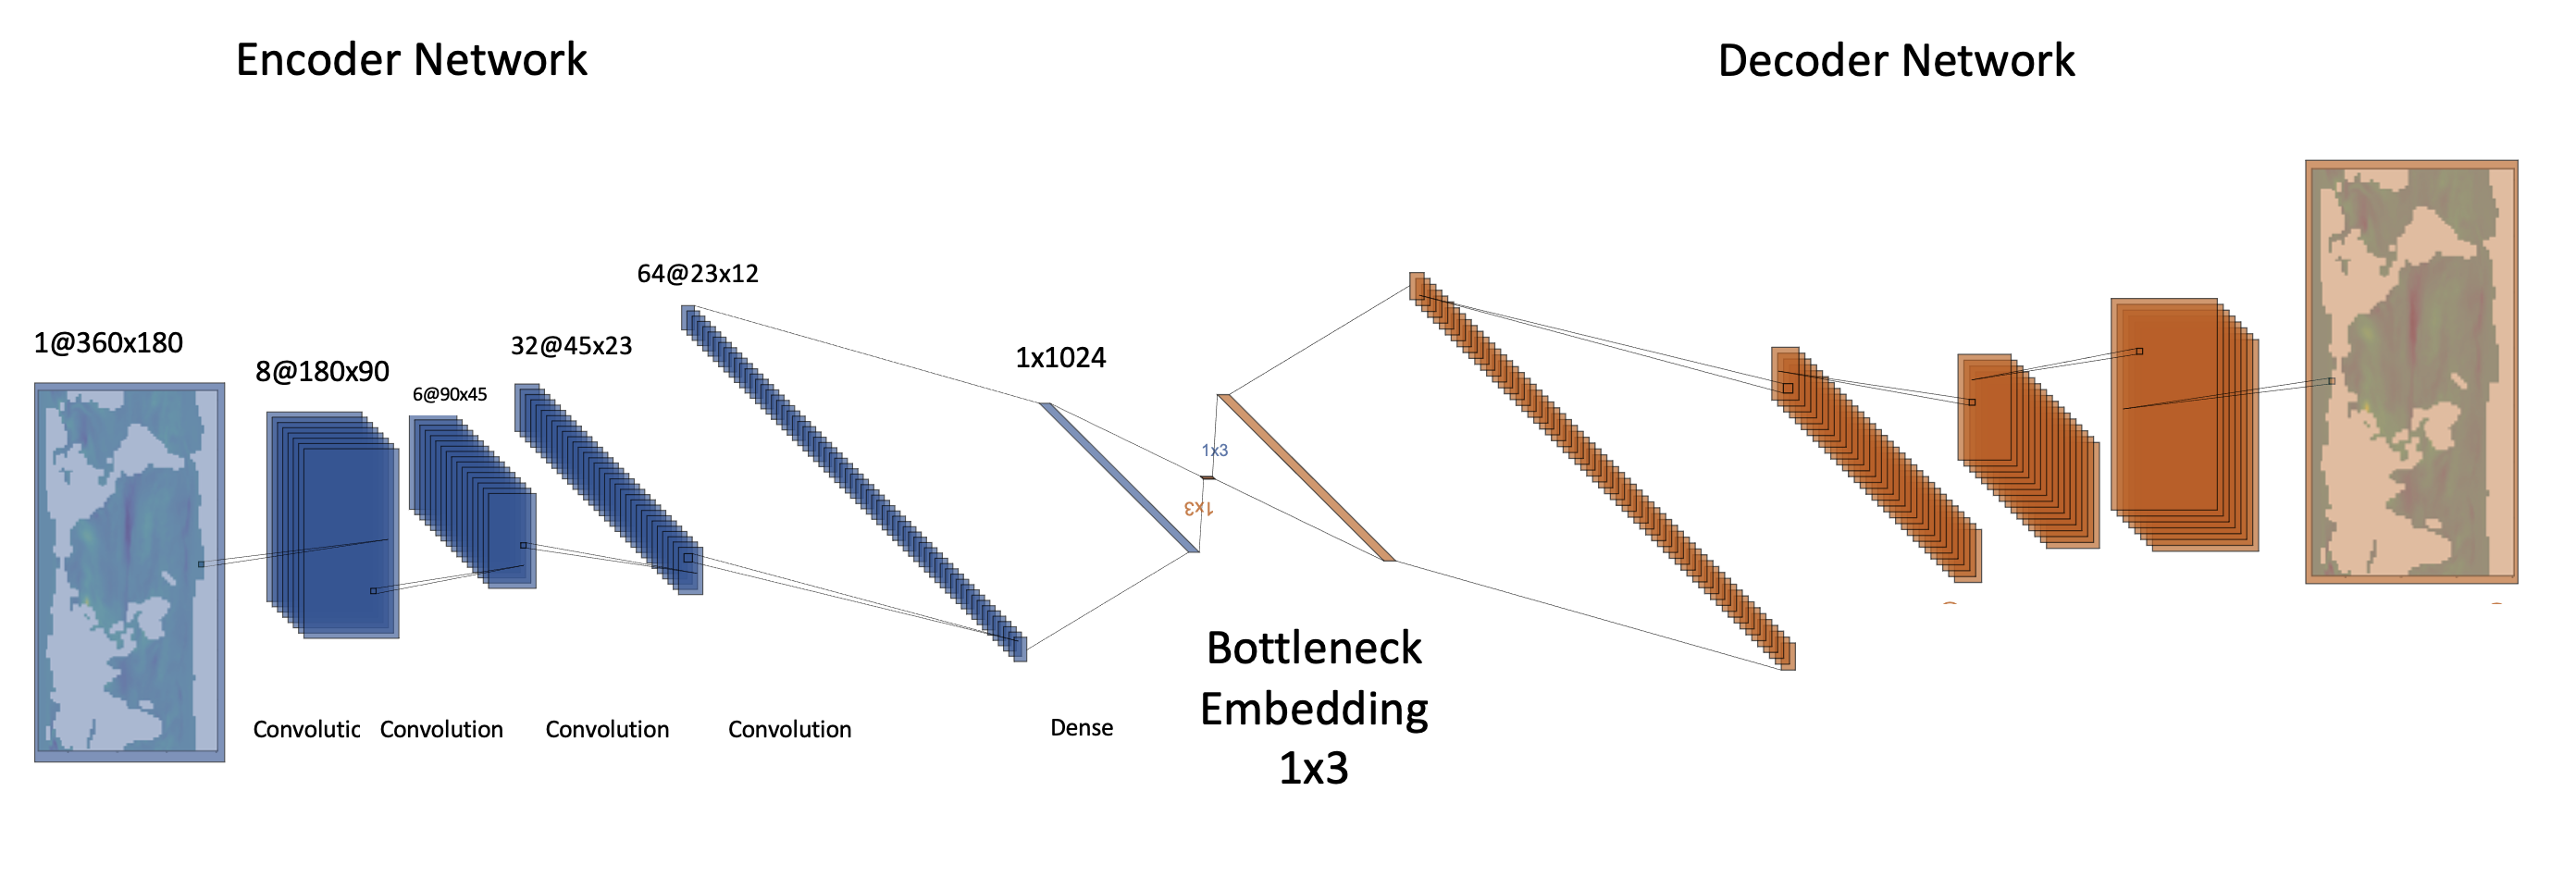

**Figure 2**. Autoencoder network structure


After training, the encoder network is used to construct embeddings for each month’s detrended and deseasoned SST. The resulting embedding vector is then concatenated to all seen data points of the same month, forming a 16-entry augmented input tensor for each observation. The augmented input tensor is then fed into xgboost and trained using the default parameter.  


#### Define and train the autoencoder netowork

In [ ]:
# encoder and decoder network definition, the encoded_space_dim is the dimension of the bottleneck layer.
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 5, stride=2, padding=2),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 5, stride=2, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 5, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 5, stride=2, padding=2),
            nn.ReLU(True),
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(64 * 23 * 12, 1024),
            nn.ReLU(True),
            nn.Linear(1024, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 64 * 23 * 12),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(64, 23, 12))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 5, 
            stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=2, 
            padding=2, output_padding=(1,0)),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=2, 
            padding=2, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 5, stride=2, 
            padding=2, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        return x

In [ ]:
# remove the seasonal cycle in the detrend sst dataseries
def remove_seasonal_cycle(data_series, time=421, xlon=360, ylat=180, period=12):
    data=torch.tensor(data_series.values.reshape(time, xlon, ylat)).float()
    for i in range(period):
        sel=(torch.arange(421) + 1) % 12 == i
        data[sel]=data[sel]-torch.mean(data[sel], axis=0)
    return data

# dataset for the autoencoder
class AutodncoderDataset(Dataset):
    def __init__(self, data_series, replacement_val=0, time=421, xlon=360, ylat=180):
        if type(data_series)==pd.core.series.Series:
            self.data = torch.tensor(data_series.values.reshape(time, xlon, ylat)).float()
        elif type(data_series)==torch.Tensor:
            self.data=data_series
        
        # shuffle data when shuffle flag in enabled
        #if shuffle:
        #    self.data = self.data[torch.randperm(self.data.shape[0])]
        
        # extract nan mask 
        self.mask=torch.isnan(self.data)
        self.mask=~torch.any(~self.mask, dim=0)
        
        # convert nan to placeholder value
        self.data=torch.nan_to_num(self.data, replacement_val)
        
        # time dimension
        self.time=time
        self.xlon=xlon
        self.ylat=ylat
        
    def __len__(self):
        return self.time

    def __getitem__(self, idx):
        item = self.data[idx] 
        return item[None,:], self.mask[None, :]
    
# function for computing autoencoder loss while making continental regions
def masked_loss(output, target, mask):
    diff=(output - target) * ~mask
    loss = torch.mean((diff)**2)
    return loss

In [ ]:
sst_no_seasonal = remove_seasonal_cycle(df["sst_detrend"])
sst_no_seasonal_train = sst_no_seasonal[0:360]
sst_no_seasonal_val = sst_no_seasonal[360:]
all_dataset = AutodncoderDataset(sst_no_seasonal, time=sst_no_seasonal.shape[0])
train_dataset = AutodncoderDataset(sst_no_seasonal_train, time=sst_no_seasonal_train.shape[0])
val_dataset = AutodncoderDataset(sst_no_seasonal_train, time=sst_no_seasonal_val.shape[0])

In [ ]:
### Define the loss function
loss_fn = masked_loss

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 3

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d)
decoder = Decoder(encoded_space_dim=d)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=3, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=17664, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(64, 23, 12))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 0))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(8, 1, kerne

In [ ]:
### Training function
def autoencoder_train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, mask in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch, mask)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

### Testing function
def autoencoder_test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    val_loss=[]
    with torch.no_grad(): # No need to track the gradients
        for image_batch, mask in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
             # Evaluate loss
            loss = loss_fn(decoded_data, image_batch, mask)
            val_loss.append(loss.detach().cpu().numpy())
    return np.mean(val_loss)

In [ ]:
batch_size=24
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
all_loader = torch.utils.data.DataLoader(all_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
num_epochs = 100
diz_loss = {'train_loss':[],'val_loss':[]}
best_val_loss=1e9
no_improvement=0
patience=5
for epoch in range(num_epochs):
    train_loss =autoencoder_train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
    val_loss = autoencoder_test_epoch(encoder,decoder,device,val_loader,loss_fn)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss, val_loss))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
    if val_loss < best_val_loss:
        best_val_loss=val_loss
        no_improvement=0
    else:
        no_improvement=no_improvement + 1
    if no_improvement > patience:
        print("Early stopping epoch: {}".format(epoch+1))
        break


 EPOCH 1/100 	 train loss 0.195 	 val loss 0.196

 EPOCH 2/100 	 train loss 0.192 	 val loss 0.186

 EPOCH 3/100 	 train loss 0.191 	 val loss 0.196

 EPOCH 4/100 	 train loss 0.190 	 val loss 0.186

 EPOCH 5/100 	 train loss 0.186 	 val loss 0.180

 EPOCH 6/100 	 train loss 0.182 	 val loss 0.180

 EPOCH 7/100 	 train loss 0.178 	 val loss 0.178

 EPOCH 8/100 	 train loss 0.174 	 val loss 0.171

 EPOCH 9/100 	 train loss 0.170 	 val loss 0.159

 EPOCH 10/100 	 train loss 0.164 	 val loss 0.154

 EPOCH 11/100 	 train loss 0.157 	 val loss 0.143

 EPOCH 12/100 	 train loss 0.150 	 val loss 0.139

 EPOCH 13/100 	 train loss 0.145 	 val loss 0.134

 EPOCH 14/100 	 train loss 0.141 	 val loss 0.127

 EPOCH 15/100 	 train loss 0.138 	 val loss 0.130

 EPOCH 16/100 	 train loss 0.134 	 val loss 0.126

 EPOCH 17/100 	 train loss 0.131 	 val loss 0.128

 EPOCH 18/100 	 train loss 0.130 	 val loss 0.125

 EPOCH 19/100 	 train loss 0.127 	 val loss 0.115

 EPOCH 20/100 	 train loss 0.124 	 val 

In [ ]:
torch.save(encoder.state_dict(), f"{root_dir}/models/trained/encoder_save.pickle")
torch.save(decoder.state_dict(), f"{root_dir}/models/trained/decoder_save.pickle")

In [ ]:
encoder = Encoder(encoded_space_dim=d)
decoder = Decoder(encoded_space_dim=d)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device);
decoder.to(device);
num_epochs = 68
diz_loss = {'train_loss':[]}
best_val_loss=1e9
no_improvement=0
patience=5
print("Now retrain with epoch number from early stopping using all parameters")
for epoch in range(num_epochs):
    train_loss =autoencoder_train_epoch(encoder,decoder,device,all_loader,loss_fn,optim)
    print('\n EPOCH {}/{} \t train loss {:.3f}'.format(epoch + 1, num_epochs,train_loss))
    diz_loss['train_loss'].append(train_loss)

Selected device: cpu
Now retrain with epoch number from early stopping using all parameters

 EPOCH 1/68 	 train loss 0.236

 EPOCH 2/68 	 train loss 0.200

 EPOCH 3/68 	 train loss 0.200

 EPOCH 4/68 	 train loss 0.194

 EPOCH 5/68 	 train loss 0.190

 EPOCH 6/68 	 train loss 0.184

 EPOCH 7/68 	 train loss 0.178

 EPOCH 8/68 	 train loss 0.170

 EPOCH 9/68 	 train loss 0.160

 EPOCH 10/68 	 train loss 0.154

 EPOCH 11/68 	 train loss 0.150

 EPOCH 12/68 	 train loss 0.147

 EPOCH 13/68 	 train loss 0.143

 EPOCH 14/68 	 train loss 0.141

 EPOCH 15/68 	 train loss 0.138

 EPOCH 16/68 	 train loss 0.136

 EPOCH 17/68 	 train loss 0.133

 EPOCH 18/68 	 train loss 0.134

 EPOCH 19/68 	 train loss 0.131

 EPOCH 20/68 	 train loss 0.129

 EPOCH 21/68 	 train loss 0.130

 EPOCH 22/68 	 train loss 0.127

 EPOCH 23/68 	 train loss 0.125

 EPOCH 24/68 	 train loss 0.123

 EPOCH 25/68 	 train loss 0.122

 EPOCH 26/68 	 train loss 0.121

 EPOCH 27/68 	 train loss 0.120

 EPOCH 28/68 	 train loss

#### Examine the ability of the autoencoder to reconstruct original SST pattern

Here we examine the ability of the autoencoder to reconstruct the original SST pattern. With 3-entry embedding, we can recover the most important modes of variabilities in the ocean SST pattern such as ENSO. Although better reconstructs can be made by increasing the size of the embedding dimension, we decide to keep the embedding size small so as to not overwhelm the local features.

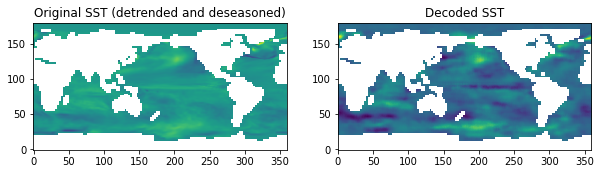

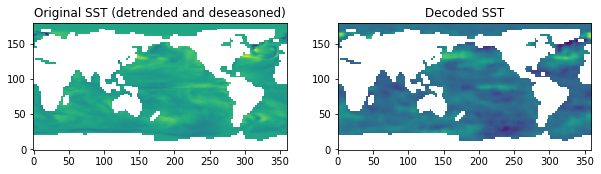

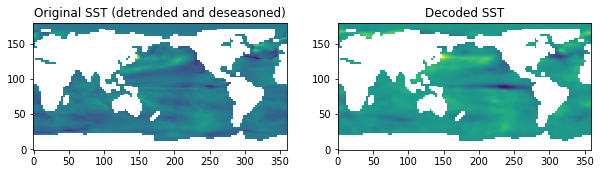

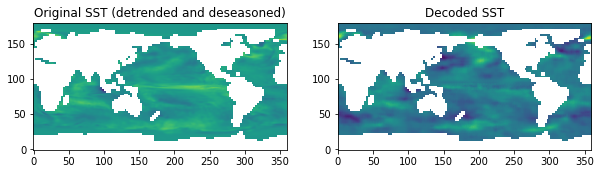

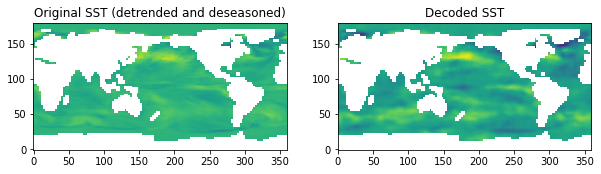

In [ ]:
#@title
for i in range(5):
    dat, mask=next(iter(val_loader))
    ma=mask[0][0]
    da=dat[0][0]
    with torch.no_grad():
        enc=encoder(da[None, None, :])
        dec=decoder(enc)
    one_nan=torch.ones(360, 180)
    one_nan[ma]=np.nan
    fig, axs=plt.subplots(1,2, figsize=(10, 20))
    ax=axs.flatten()
    ax[0].imshow((da * one_nan).T, origin="lower")
    ax[0].set_title("Original SST (detrended and deseasoned)")
    ax[1].imshow((dec[0][0] * one_nan).T, origin="lower")
    ax[1].set_title("Decoded SST")
    plt.show()

#### Apply the encoded ocean state to the xgboost model

In [ ]:
features_sel = ['sst_detrend', 'sst_anom', 'sss', 'sss_anom', 'mld_clim_log', 'chl_log', 'chl_anom', 'xco2', 'A', 'B', 'C', 'T0', 'T1']
target_sel = ['pCO2']
# 816 represents 3 standard deviations above mean in SOCAT data -- observations above this threshold are unrealistic to observe in real-world data
recon_sel = (~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)) & (df[target_sel] < 816).to_numpy().ravel()
sel = (recon_sel & (df['socat_mask'] == 1))
unseen_sel = (recon_sel & (df['socat_mask'] == 0))
        
 # Convert dataframe to numpy arrays, train/val/test split
X = df.loc[sel,features_sel].to_numpy()
y = df.loc[sel,target_sel].to_numpy().ravel()

# Using the trained encoder to construct ocean state embeddings
with torch.no_grad():
    encoded_sst_detrend_no_season=encoder(torch.nan_to_num(sst_no_seasonal, 0)[:, None, :])

# Attach the embedding to the original input matrix
enc_repeat=encoded_sst_detrend_no_season.repeat_interleave(360*180, dim=0)
X=np.hstack((X,enc_repeat[sel.to_numpy()].numpy()))
                

In [ ]:
val_prop = .2
test_prop = .2
N = X.shape[0]
train_val_idx, train_idx, val_idx, test_idx = pre.train_val_test_split(N, test_prop, val_prop)
X_train_val, X_train, X_val, X_test, y_train_val, y_train, y_val, y_test = pre.apply_splits(X, y, train_val_idx, train_idx, val_idx, test_idx) 

In [ ]:
# Fit the model on train/validation data
# it take 17 seconds to train the model
model = XGBRegressor(n_jobs=1)
model.fit(X_train_val, y_train_val)          
# Save the model
approach = "xg_cnn"
pre.save_model(model, model_output_dir, approach, ens, member)

Starting model saving process
Save complete


In [ ]:
# Calculate some test error metrics and store in a dictionary
test_performance = defaultdict(dict)
y_pred_test = model.predict(X_test)
test_performance[ens][member] = pre.evaluate_test(y_test, y_pred_test)

In [ ]:
# Redo this analysis on the unseen data
unseen_performance = defaultdict(dict)
y_pred_unseen = model.predict(np.hstack((df.loc[unseen_sel,features_sel].to_numpy(), enc_repeat[unseen_sel.to_numpy()].numpy())))
y_unseen = df.loc[unseen_sel,target_sel].to_numpy().ravel()
unseen_performance[ens][member] = pre.evaluate_test(y_unseen, y_pred_unseen)

In [ ]:
model.feature_importances_

array([0.16499954, 0.04738782, 0.02411203, 0.05269795, 0.05968868,
       0.01078528, 0.1484774 , 0.17101008, 0.13199218, 0.05227261,
       0.02221586, 0.05981573, 0.02684642, 0.00935849, 0.0094943 ,
       0.00884564], dtype=float32)

In [ ]:
print(test_performance)
print(unseen_performance)

defaultdict(<class 'dict'>, {'CanESM2': {'r1r10': {'mse': 105.66709, 'mae': 6.7043285, 'medae': 4.96286, 'max_error': 273.02097, 'bias': 0.0021972656, 'r2': 0.9314836877547382, 'corr': 0.9652021538439027, 'cent_rmse': 10.279449951478535, 'stdev': 37.45419, 'amp_ratio': 0.88701093, 'stdev_ref': 39.271084, 'range_ref': 585.4325, 'iqr_ref': 50.966636657714844}}})
defaultdict(<class 'dict'>, {'CanESM2': {'r1r10': {'mse': 357.30432, 'mae': 10.418321, 'medae': 7.1763306, 'max_error': 530.1797, 'bias': 0.5982971, 'r2': 0.7634256499217251, 'corr': 0.8740829744029662, 'cent_rmse': 18.89303582402974, 'stdev': 34.704945, 'amp_ratio': 0.90259045, 'stdev_ref': 38.86292, 'range_ref': 694.08203, 'iqr_ref': 47.25750732421875}}})


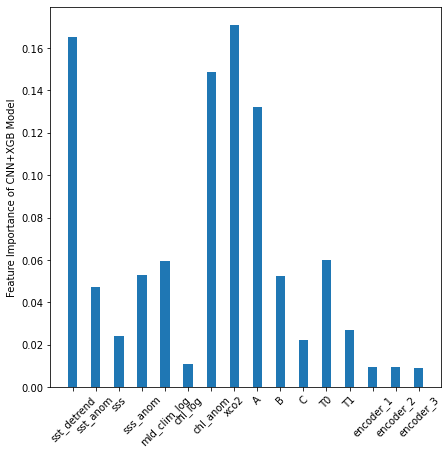

In [ ]:
feature_importance=[0.16499954, 0.04738782, 0.02411203, 0.05269795, 0.05968868,
       0.01078528, 0.1484774 , 0.17101008, 0.13199218, 0.05227261,
       0.02221586, 0.05981573, 0.02684642, 0.00935849, 0.0094943 ,
       0.00884564]
labels=['sst_detrend','sst_anom','sss','sss_anom',
       'mld_clim_log','chl_log','chl_anom','xco2',
       'A','B','C','T0','T1',
       'encoder_1', 'encoder_2', 'encoder_3']
fig, axs=plt.subplots(1, 1, figsize=(7, 7))
axs.bar(np.arange(0, 32, 2), feature_importance)
axs.set_xticks(np.arange(0, 32, 2))
axs.set_xticklabels(labels, rotation=45)
axs.set_ylabel("Feature Importance of CNN+XGB Model")
plt.show()

From the feature importance plot it can be seen that the global embeddings have very small effect on the xgboost model. This suggests that contrary to our expectation, the global ocean modes of varabilities have very little impact on the local pCO2 level.

### Part VI: Compare the RNN and CNN Autoencoder models with the baseline XGB model

In [ ]:
#@title
print("Comparison of test statstics on unseen dataset for baseline xgboost, RNN, and CNN\n")

baseline_dict={'mse': 325.06485, 'mae': 10.300415, 'medae': 7.195404, 'max_error': 544.3163, 'bias': 0.77386475, 'r2': 0.7847717994645761, 'cent_rmse': 18.01292902280759, 'stdev': 34.932484, 'amp_ratio': 0.8692974, 'stdev_ref': 38.86292, 'range_ref': 694.08203, 'iqr_ref': 47.25750732421875}
rnn_dict={'mse': 336.6129, 'mae': 10.479534, 'medae': 7.215393, 'max_error': 543.01385, 'bias': -0.7720947, 'r2': 0.7759732974788542, 'cent_rmse': 18.33075739030476, 'stdev': 35.934338, 'amp_ratio': 0.98780125, 'stdev_ref': 38.76283, 'range_ref': 694.08203, 'iqr_ref': 47.1009521484375}
cnn_dict={'mse': 357.30432, 'mae': 10.418321, 'medae': 7.1763306, 'max_error': 530.1797, 'bias': 0.5982971, 'r2': 0.7634256499217251, 'cent_rmse': 18.89303582402974, 'stdev': 34.704945, 'amp_ratio': 0.90259045, 'stdev_ref': 38.86292, 'range_ref': 694.08203, 'iqr_ref': 47.25750732421875}
print("\t {:10s} \t {:10s} \t {:10s} \t {:10s}".format("METRIC", "XGB", "RNN", "CNN + XGB"))
print("\t____________________________________________________________")
for key in baseline_dict:
    print("\t|{:10s}| \t {:10.3f}| \t {:10.3f}| \t {:10.3f}|".format(key, baseline_dict[key], rnn_dict[key], cnn_dict[key]))

Comparison of test statstics on unseen dataset for baseline xgboost, RNN, and CNN

	 METRIC     	 XGB        	 RNN        	 CNN + XGB 
	____________________________________________________________
	|mse       | 	    325.065| 	    336.613| 	    357.304|
	|mae       | 	     10.300| 	     10.480| 	     10.418|
	|medae     | 	      7.195| 	      7.215| 	      7.176|
	|max_error | 	    544.316| 	    543.014| 	    530.180|
	|bias      | 	      0.774| 	     -0.772| 	      0.598|
	|r2        | 	      0.785| 	      0.776| 	      0.763|
	|cent_rmse | 	     18.013| 	     18.331| 	     18.893|
	|stdev     | 	     34.932| 	     35.934| 	     34.705|
	|amp_ratio | 	      0.869| 	      0.988| 	      0.903|
	|stdev_ref | 	     38.863| 	     38.763| 	     38.863|
	|range_ref | 	    694.082| 	    694.082| 	    694.082|
	|iqr_ref   | 	     47.258| 	     47.101| 	     47.258|


## Discussion
We hypothesized that incorporating recent time series of physical variables in a recurrent neural network will reduce prediction loss by implicitly taking account of the time lag between the physical drivers and the ocean pCO2 level. Furthermore, we also hypothesized that using an encoding of the ocean SST as additional input features can improve the prediction of pCO2 by providing a representation of the global ocean background state.

However, the performances of the RNN and CNN-autoencoder models on the unseen data do not support the two hypotheses. For the RNN network, the MSE of the prediction is approximately the same as the baseline xgboost model on the unseen dataset. For the CNN-autoencoder network, including the spatial embedding decreases the bias on the seen dataset but slightly increases the bias in the unseen dataset. The small feature importance of the embedding suggests that local features have a predominate role in predicting the pCO2 level. Overall, we see no significant differences in the performances of the RNN and CNN-autoencoder models with the baseline xgboost model. Therefore, our results suggest that ocean pCO2 is mostly driven by local processes with a relatively short response time to the physical drivers.

It should be noted that the interpretation above should not be accepted without several qualifications. First, in training the model, we used a dataset with comparatively coarse spatial (1-degree x 1-degree) and temporal (monthly) resolution, so it is possible that many temporal and spatial dependencies between the physical processes and the ocean pCO2 level cannot be fully resolved at the existing resolution. If a higher resolution dataset were used for the prediction, we might observe more significant temporal and spatial dependencies. Second, we did not extensively train tune the hyperparameters out of both time constraints and concerns that the performance gain might come from hyperparameter tuning rather than underlying statistical relations. Finally, the model is trained on the very sparse SOCAT dataset, and different results might emerge if a more densely sampled dataset were available.


# Method 2: Use Semi-Parametric Approach to Reconstruct pCO2

In this method, we will implement three approaches to reconstruct the pCO2.

1:XGBoost

2:Projection Pursuit Model

3:Partially Linear Model

Approach 2 and 3 are two semi-parametric model

Back to the very beginning of learning a set of data, We would give the dataset some assumptions, like suppose that 
${X_1, X_2,...Xn}∼N(ζ, 1)$, we will call it the Parametric Model Since there are some parameters we need to estimate.  One of the main challenges of parametric model is finding the right basis to describe the g function well, unfortunately, this is a non-trivial problem. In such cases, we use nonparametric approaches. We only assume that those functions are differentiable or smooth. There are advantages and disadvantages to parametric and non-parametric models.

Fully parametric models and fully nonparametric models should be considered as the two extremes of the spectrum of algorithms we use to model data sets. If we have small datasets (the number of observations(n)  is relatively smaller than the number of features). and if we have an infinitely large dataset, we might want to do a fully nonparametric regression. However, most data sets are neither too small nor infinitely large. So we would consider combining them or imposing more
restrictions on function g in the full nonparametric model. Our approaches 2 and 3 are semi-parametric models. More details will be mentioned in the following part.

## Part I Train / validate reconstruction model 

In [ ]:
#@title XGBoost Regressor
# Fit the model on train/validation data
# it take 17 seconds to train the model
model = XGBRegressor(n_jobs=1)
model.fit(X_train_val, y_train_val)          

# Save the model
pre.save_model(model, model_output_dir, approach, ens, member)

# Calculate some test error metrics and store in a dictionary
test=defaultdict(dict)
test_performance = defaultdict(dict)
y_pred_test = model.predict(X_test)
test[approach] = pre.evaluate_test(y_test, y_pred_test)
test_performance[ens][member] = pre.evaluate_test(y_test, y_pred_test)
# Redo this analysis on the unseen data
unseen_performance = defaultdict(dict)
unseen=defaultdict(dict)
y_pred_unseen = model.predict(df.loc[unseen_sel,features_sel].to_numpy())
y_unseen = df.loc[unseen_sel,target_sel].to_numpy().ravel()
unseen_performance[ens][member] = pre.evaluate_test(y_unseen, y_pred_unseen)
unseen[approach]=pre.evaluate_test(y_unseen, y_pred_unseen)
print(test_performance)
print(unseen_performance)

y_pred_seen = model.predict(X)
df['pCO2_recon'] = np.nan
df.loc[unseen_sel,['pCO2_recon']] = y_pred_unseen
df.loc[sel,['pCO2_recon']] = y_pred_seen
DS_recon = df[['net_mask','socat_mask','pCO2', 'pCO2_recon']].to_xarray()
pre.save_recon(DS_recon, recon_output_dir, approach, ens, member)

# Convert performance metrics to dataframes
test_df = pd.DataFrame.from_dict({(i,j): test_performance[i][j]
                                  for i in test_performance.keys()
                                  for j in test_performance[i].keys()},
                                 orient='index')

unseen_df = pd.DataFrame.from_dict({(i,j): unseen_performance[i][j]
                                  for i in unseen_performance.keys()
                                  for j in unseen_performance[i].keys()},
                                 orient='index')

test_df.index.names = ["model","member"]
unseen_df.index.names = ["model","member"]

# Save the dataframes too
test_df_fname = f"{approach_output_dir}/{approach}_test_performance_df.pickle"
unseen_df_fname = f"{approach_output_dir}/{approach}_unseen_performance_df.pickle"

test_df.to_pickle(test_df_fname)
unseen_df.to_pickle(unseen_df_fname)

[19:09:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Starting model saving process
Save complete
defaultdict(<class 'dict'>, {'CanESM2': {'r1r10': {'mse': 347.3555, 'mae': 12.518245, 'medae': 9.415115, 'max_error': 406.04205, 'bias': 0.05795288, 'r2': 0.7709698230475753, 'corr': 0.8825636835202303, 'cent_rmse': 18.637384743204816, 'stdev': 30.898956, 'amp_ratio': 0.5018683, 'stdev_ref': 38.944016, 'range_ref': 569.3942, 'iqr_ref': 51.15171813964844}}})
defaultdict(<class 'dict'>, {'CanESM2': {'r1r10': {'mse': 570.7183, 'mae': 14.628633, 'medae': 10.693329, 'max_error': 517.2141, 'bias': 2.5503845, 'r2': 0.622122362661681, 'corr': 0.7940400072106326, 'cent_rmse': 23.753189075108285, 'stdev': 28.379217, 'amp_ratio': 0.50404906, 'stdev_ref': 38.86292, 'range_ref': 694.08203, 'iqr_ref': 47.25750732421875}}})
Starting reconstruction saving process
Save complete


### Projection Pursuit Regressor

In this model, we assume that:
$Y=g(w_1^{0}+∑_{i=1}^p(w_1^iX^i))+ϵ $

we have to learn the smooth functions g, and the regression coefficients $w_1$. Then we look at the residual $Y-g(w_1^{0}+∑_{i=1}^p(w_1^iX^i))) $ and try to using all the features to predict the residual, which means we let $Y-g(w_1^TX)=g_2(w_2^T X)+ϵ_2 $ and we learn w2 and g2 continue this process until we do not get much improvement

Training by this approach costs about 10 minutes. we can just train it once and then get the model from the outputfile.
If you open this file for the first time then run the following two coding parts. Otherwise, you can only run the second coding part.

In [ ]:
#@title Training data with PPM 
# Fit the model on train/validation data
# it take 10 minutes to fit the model
ppm = ProjectionPursuitRegressor()
ppm.fit(X_train_val, y_train_val)          
# Save the model
pre.save_model(ppm, model_output_dir, approach2, ens, member)

In [ ]:
#@title Read PPM model and reconstruct the data

model_dir=f"{model_output_dir}/{approach2}/{ens}/member_{member}"
model_fname = f"{model_dir}/{approach2}_model_pC02_2D_mon_{ens}_{member}_1x1_198201-201701.joblib"
ppm = joblib.load(model_fname)

# Calculate some test error metrics and store in a dictionary
test_performance_ppm = defaultdict(dict)
y_pred_test = ppm.predict(X_test)
test_performance_ppm[ens][member] = pre.evaluate_test(y_test, y_pred_test)

# Redo this analysis on the unseen data
unseen_performance_ppm = defaultdict(dict)
y_pred_unseen = ppm.predict(df.loc[unseen_sel,features_sel].to_numpy())
y_unseen = df.loc[unseen_sel,target_sel].to_numpy().ravel()
unseen_performance_ppm[ens][member] = pre.evaluate_test(y_unseen, y_pred_unseen)
test[approach2] = pre.evaluate_test(y_test, y_pred_test)
unseen[approach2]=pre.evaluate_test(y_unseen, y_pred_unseen)
print(test_performance_ppm)
print(unseen_performance_ppm)

y_pred_seen = ppm.predict(X)
df['pCO2_recon'] = np.nan
df.loc[unseen_sel,['pCO2_recon']] = y_pred_unseen
df.loc[sel,['pCO2_recon']] = y_pred_seen
DS_recon = df[['net_mask','socat_mask','pCO2', 'pCO2_recon']].to_xarray()
pre.save_recon(DS_recon, recon_output_dir, approach2, ens, member)

# Convert performance metrics to dataframes
test_df = pd.DataFrame.from_dict({(i,j): test_performance_ppm[i][j]
                                  for i in test_performance_ppm.keys()
                                  for j in test_performance_ppm[i].keys()},
                                 orient='index')

unseen_df = pd.DataFrame.from_dict({(i,j): unseen_performance_ppm[i][j]
                                  for i in unseen_performance_ppm.keys()
                                  for j in unseen_performance_ppm[i].keys()},
                                 orient='index')

test_df.index.names = ["model","member"]
unseen_df.index.names = ["model","member"]

# Save the dataframes too
test_df_fname = f"{approach_output_dir}/{approach2}_test_performance_ppm_df.pickle"
unseen_df_fname = f"{approach_output_dir}/{approach2}_unseen_performance_ppm_df.pickle"

test_df.to_pickle(test_df_fname)
unseen_df.to_pickle(unseen_df_fname)

### Partially Linear Regressor

One of the main advantages of paramatric model(especially Linear model) is that it could make model more interpretable. And the increasing dimension does not affect these models as much as the non-parametric models.
We assume that $ Y = β_0 + β_1X^1 + . . . + + β_lX^l + g(X^{l+1}...X^p)$

To gain g and the parameters, We first construct a new dataset $(X_1, \bar Y_1),(X_2, \bar Y_2), . . . ,(X_n, \bar Y_n)$
in the following way:
$\bar Y_i=Y_i-\sum_{j=1}^l \hat β_j X_i^{(j)}$

and with  $(X_1, \bar Y_1),(X_2, \bar Y_2), . . . ,(X_n, \bar Y_n)$, we update g, Spline is a non-parametric method people usually used for Partially Linear model. But in this project. We use XGBoost to estimate the non-linear part.

then we construct a new dataset$(X_1, \hat Y_1),(X_2, \hat Y_2), . . . ,(X_n, \hat Y_n)$ in the following way:
$\hat Y_i= Y_i - g(X_i^{(l+1)},...X_i^{(p)})$

We continue this process until the algorithm does not improve much

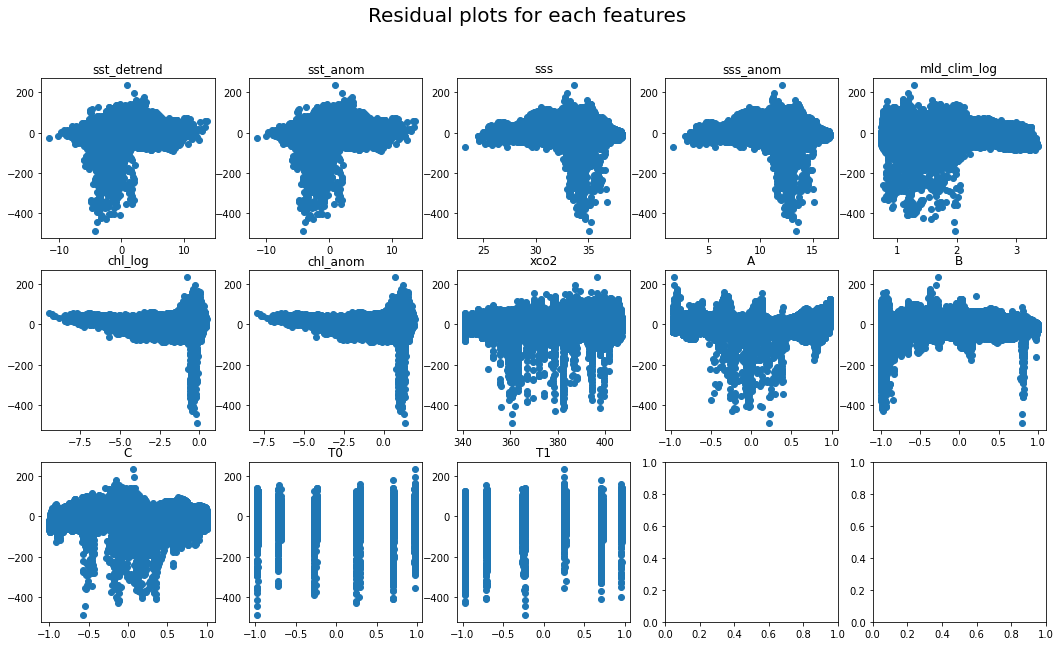

In [ ]:
#@title Decide linear part
Linearmodel = LinearRegression()
model1=Linearmodel.fit(X_train_val, y_train_val)
pred=model1.predict(X_train_val)
error=pred-y_train_val

#plot the error and y to decide linear and other part
fig, axs = plt.subplots(3,5)
for i in range(13):
    axs[int(i/5),i%5].scatter(X_train_val[:,i],error)
    axs[int(i/5),i%5].set_title(features_sel[i])
fig.suptitle("Residual plots for each features",fontsize=20)
fig.set_size_inches(18, 10)   

While deciding the Linear part, we firstly using Linear regressor to gain the parameters for each variable, then plot the residual plots for 13 features seperately. Find the variables whose residual plot seems the most "random". We say those features are Linear part and others are non-parametric part.

In [ ]:
#@title Patially Linear Model training
non_pa=[0,1,2,3,4,5,6,8,9,10]
pa=[7,11,12]

X_train_val_pa=X_train_val[:,pa]
X_train_val_non=X_train_val[:,non_pa]
X_test_pa=X_test[:,pa]
X_test_non=X_test[:,non_pa]
cons=np.sum(model1.coef_[pa]*X_train_val_pa,axis=1)
y_train_val_non=y_train_val-cons
nonpamodel = XGBRegressor(n_jobs=1)
nonpamodel.fit(X_train_val_non, y_train_val_non)
diff=5
while  diff>0.01:
   y_train_val_non_new=nonpamodel.predict(X_train_val_non)
   y_train_val_pa=y_train_val-y_train_val_non_new
   linear=Linearmodel.fit(X_train_val_pa, y_train_val_pa)
   cons=linear.predict(X_train_val_pa)
   y_train_val_non=y_train_val-cons
   nonpamodel2= XGBRegressor(n_jobs=1).fit(X_train_val_non,y_train_val_non)
   diff2=np.absolute(nonpamodel2.predict(X_train_val_non)-y_train_val_non_new).mean(axis=0)
   if diff2-diff>0:
     break
   print(diff2)
   diff=diff2
   nonpamodel=nonpamodel2

# model predict
y_pre_non=nonpamodel.predict(X_test_non)
y_pre_pa=linear.predict(X_test_pa)
y_pred_test=y_pre_non+y_pre_pa
pre.save_model(nonpamodel, model_output_dir, approach3, ens, member)

#Linear coeficient
print("The coeficient of linear part (pCO2,T0,T1)",linear.coef_)


# Calculate some test error metrics and store in a dictionary
test_performance_pl = defaultdict(dict)
test_performance_pl[ens][member] = pre.evaluate_test(y_test, y_pred_test)
# Redo this analysis on the unseen data
unseen_performance_pl = defaultdict(dict)
unseen_da=df.loc[unseen_sel,features_sel].to_numpy()
Y_pred_xgb_unseen=nonpamodel.predict(unseen_da[:,non_pa])
Y_pred_para_unseen=linear.predict(unseen_da[:,pa])
y_pred_unseen=Y_pred_para_unseen+Y_pred_xgb_unseen
y_unseen=df.loc[unseen_sel,target_sel].to_numpy().ravel()
unseen_performance_pl[ens][member] = pre.evaluate_test(y_unseen, y_pred_unseen)
test[approach3] = pre.evaluate_test(y_test, y_pred_test)
unseen[approach3]=pre.evaluate_test(y_unseen, y_pred_unseen)
print(test_performance_pl)
print(unseen_performance_pl)

y_pred_seen = nonpamodel.predict(X[:,non_pa])+linear.predict(X[:,pa])
df['pCO2_recon'] = np.nan
df.loc[unseen_sel,['pCO2_recon']] = y_pred_unseen
df.loc[sel,['pCO2_recon']] = y_pred_seen
DS_recon = df[['net_mask','socat_mask','pCO2', 'pCO2_recon']].to_xarray()
pre.save_recon(DS_recon, recon_output_dir, approach3, ens, member)

# save test and unseen result
test1=pd.DataFrame(test)
test1.to_csv(data_output_dir+"test.csv")
unseen1=pd.DataFrame(unseen)
unseen1.to_csv(data_output_dir+"unseen.csv")

##Part II Performance Comparision

In [ ]:
#@title Pulling in test and unssen data performance
test1=pd.read_csv(data_output_dir+"test.csv",index_col=0)
unseen1=pd.read_csv(data_output_dir+"unseen.csv",index_col=0)

In [ ]:
#@title test performance matrix
test1

,xg,ppm,part_ln
mse,336.445160,370.960893,320.406396
mae,12.541768,13.456309,12.210436
medae,9.473923,10.321675,9.254607
max_error,331.588531,315.163756,313.235503
bias,0.304657,0.245419,0.294557
r2,0.777438,0.754605,0.788047
corr,0.885961,0.868706,0.890594
cent_rmse,18.339910,19.258781,17.897475
stdev,31.095562,33.684484,31.863051
amp_ratio,0.496730,0.709786,0.484545


In [ ]:
#@title unseen data performance 
unseen1

,xg,ppm,part_ln
mse,574.140930,609.676401,527.244827
mae,14.747478,15.740008,13.939844
medae,10.805420,11.639310,10.160814
max_error,523.913208,818.106664,517.155950
bias,2.718262,0.104159,1.636215
r2,0.619856,0.596328,0.650907
corr,0.792846,0.774167,0.808210
cent_rmse,23.806552,24.691406,22.903433
stdev,28.399031,32.214954,30.519623
amp_ratio,0.550875,1.419509,0.469734


### Compare MSEs, MAEs and correlations of three different models

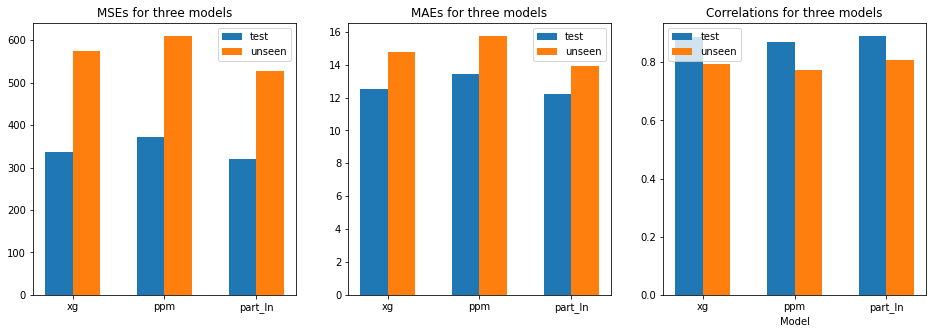

In [ ]:
#@title 
import numpy as np
import matplotlib.pyplot as plt
from pylab import mpl
import pandas as pd
from pandas import Series, DataFrame
fig,ax=plt.subplots(1,3,figsize=[16,5])
x=np.array([1,2,3])
x2 = np.arange(1,4)
y1=test1.iloc[0]
y2=unseen1.iloc[0]
ax[0].bar(x,y1,width=0.3,align="center",label="test")
ax[0].bar(x+0.3,y2,width=0.3,align="center",label="unseen")
ax[0].set_title("MSEs for three models")
ax[0].set_xticks(x2+0.15)
ax[0].set_xticklabels([approach,approach2,approach3])
ax[0].legend()
plt.xlabel("Model")
y1=test1.iloc[1]
y2=unseen1.iloc[1]
ax[1].bar(x,y1,width=0.3,align="center",label="test")
ax[1].bar(x+0.3,y2,width=0.3,align="center",label="unseen")
ax[1].set_title("MAEs for three models")
ax[1].set_xticklabels([approach,approach2,approach3])
ax[1].set_xticks(x2+0.15)
ax[1].legend()
plt.xlabel("Model")
y1=test1.iloc[6]
y2=unseen1.iloc[6]
ax[2].bar(x,y1,width=0.3,align="center",label="test")
ax[2].bar(x+0.3,y2,width=0.3,align="center",label="unseen")
ax[2].set_title("Correlations for three models")
ax[2].set_xticks(x2+0.15)
ax[2].set_xticklabels([approach,approach2,approach3])
ax[2].legend()
plt.xlabel("Model")

plt.show()

it was showed that the partial linear model has the lowest MSE and MAE while Projection Pursuit model got the largest. The correlations for three models are close, the correaltion for Projection Pursuit model is the lowest among three.

In [ ]:
#@title Delete some variables in case the file collapse
del X_train_val, X_train, X_val, X_test, y_train_val, y_train, y_val, y_test
del test_performance, unseen_performance, y_pred_test, y_pred_unseen, y_pred_seen, DS_recon, df
del test_df, unseen_df
del X_train_val_pa,X_train_val_non,y_train_val_pa,y_train_val_non,y_train_val_non_new,X_test_pa,X_test_non,Y_pred_xgb_unseen,Y_pred_para_unseen

##Part III Calculate statistical measures against original ESM pCO$_2$. 

In [ ]:
#@title Decompose reconstruction
# take 3 minutes
pre.apply_detrend(approach, ens, member)
pre.apply_detrend(approach2, ens, member)
pre.apply_detrend(approach3, ens, member)

In [ ]:
#@title XGboost deconstruction metric maps
##Full reconstruction and temporal deconstruction metric maps
# it take 20 seconds

data_types = ["raw", "seasonal", "deseason"]

map_data = defaultdict(float) # Data by ML approach
map_data_ens = defaultdict(float) # Data by ML approach and ensemble model

N_ens = 1
N_tot = 1

recon_dir = f"{recon_output_dir}/{approach}/{ens}/member_{member}"
            
recon_fname_out = f"{recon_dir}/{approach}_recon_temporal_pC02_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
            
DS_recon = xr.load_dataset(recon_fname_out)
                        
recon = {}
recon["raw"] = DS_recon["pCO2_recon"]
for i in data_types[1:]:
  recon[i] = DS_recon[f"pCO2_recon_{i}"]

ref = {}
ref["raw"] = DS_recon["pCO2"]
for i in data_types[1:]:
  ref[i] = DS_recon[f"pCO2_{i}"]
                
for i in data_types:
  xmean = ref[i].mean("time")
  ymean = recon[i].mean("time")
  x_minus_mean = ref[i] - xmean
  y_minus_mean = recon[i] - ymean
  ssx = xr.ufuncs.sqrt((x_minus_mean**2).sum("time"))
  ssy = xr.ufuncs.sqrt((y_minus_mean**2).sum("time"))
                
  corr = ( x_minus_mean * y_minus_mean ).sum("time") / (ssx*ssy)
  std_x = ref[i].std("time")
  std_y = recon[i].std("time")
  bias = (ymean - xmean)
                
                # Average bias
  map_data[(approach,i,"bias_mean")] += bias / N_tot
  map_data_ens[(ens,approach,i,"bias_mean")] += bias / N_ens
                
                # Average bias**2
  map_data[(approach,i,"bias_sq")] += bias**2 / N_tot
  map_data_ens[(ens,approach,i,"bias_sq")] += bias**2 / N_ens
                
                # Max bias
  map_data[(approach,i,"bias_max")] = np.maximum(map_data[(approach,i,"bias_max")], bias)
  map_data_ens[(ens,approach,i,"bias_max")] = np.maximum(map_data_ens[(ens,approach,i,"bias_max")], bias)
                
                # Min bias
  map_data[(approach,i,"bias_min")] = np.minimum(map_data[(approach,i,"bias_min")], bias)
  map_data_ens[(ens,approach,i,"bias_min")] = np.minimum(map_data_ens[(ens,approach,i,"bias_min")], bias)
                
                # Mean absolute error
  map_data[(approach,i,"mae")] += np.abs(bias) / N_tot
  map_data_ens[(ens,approach,i,"mae")] += np.abs(bias) / N_ens
                
                # Mean % bias
  map_data[(approach,i,"bias_%error")] += bias/xmean / N_tot
  map_data_ens[(ens,approach,i,"bias_%error")] += bias/xmean / N_ens
                
                # Mean absolute % bias
  map_data[(approach,i,"mae_%error")] += np.abs(bias)/xmean / N_tot
  map_data_ens[(ens,approach,i,"mae_%error")] += np.abs(bias)/xmean / N_ens
                
                # Mean correlation
  map_data[(approach,i,"corr_mean")] += corr / N_tot
  map_data_ens[(ens,approach,i,"corr_mean")] += corr / N_ens
                
                # Average corr**2
  map_data[(approach,i,"corr_sq")] += corr**2 / N_tot
  map_data_ens[(ens,approach,i,"corr_sq")] += corr**2 / N_ens

                # Stdev (amplitude) percentage error
  map_data[(approach,i,"amp_%error")] += (std_y-std_x)/std_x / N_tot
  map_data_ens[(ens,approach,i,"amp_%error")] += (std_y-std_x)/std_x / N_ens

                # Stdev (amplitude) absolute percentage error           
  map_data[(approach,i,"stdev_%error")] += np.abs(std_y-std_x)/std_x / N_tot
  map_data_ens[(ens,approach,i,"stdev_%error")] += np.abs(std_y-std_x)/std_x / N_ens


for i in data_types:
  map_data[(approach,i,"bias_std")] = np.sqrt(map_data[(approach,i,"bias_sq")] - map_data[(approach,i,"bias_mean")]**2)
  map_data[(approach,i,"corr_std")] = np.sqrt(map_data[(approach,i,"corr_sq")] - map_data[(approach,i,"corr_mean")]**2)

  map_data_ens[(ens,approach,i,"bias_std")] = np.sqrt(map_data_ens[(ens,approach,i,"bias_sq")] - map_data_ens[(ens,approach,i,"bias_mean")]**2)
  map_data_ens[(ens,approach,i,"corr_std")] = np.sqrt(map_data_ens[(ens,approach,i,"corr_sq")] - map_data_ens[(ens,approach,i,"corr_mean")]**2)

#Saving XGBoost map metrics
map_data_fname = f"{other_output_dir}/map_data_approach.pickle"
map_data_ens_fname = f"{other_output_dir}/map_data_ens.pickle"

with open(map_data_fname,"wb") as handle:
  pickle.dump(map_data, handle)

with open(map_data_ens_fname,"wb") as handle:
  pickle.dump(map_data_ens, handle)


In [ ]:
#@title Pulling in XGBoost map metrics
other_output_dir = f"{root_dir}/models/performance_metrics"

map_data_fname = f"{other_output_dir}/map_data_approach.pickle"
map_data_ens_fname = f"{other_output_dir}/map_data_ens.pickle"

with open(map_data_fname,"rb") as handle:
  map_data = pickle.load(handle)

with open(map_data_ens_fname,"rb") as handle:
  map_data_ens = pickle.load(handle)

In [ ]:
#@title Projection Pursuit Model deconstruction metric maps
data_types = ["raw", "seasonal", "deseason"]
map_data_ppm = defaultdict(float) # Data by ML approach
map_data_ens_ppm = defaultdict(float) # Data by ML approach and ensemble model

N_ens = 1
N_tot = 1

recon2_dir = f"{recon_output_dir}/{approach2}/{ens}/member_{member}"
            
recon2_fname_out = f"{recon2_dir}/{approach2}_recon_temporal_pC02_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
            
DS_recon2 = xr.load_dataset(recon2_fname_out)                     
recon2 = {}
recon2["raw"] = DS_recon2["pCO2_recon"]
for i in data_types[1:]:
  recon2[i] = DS_recon2[f"pCO2_recon_{i}"]

ref2 = {}
ref2["raw"] = DS_recon2["pCO2"]
for i in data_types[1:]:
  ref2[i] = DS_recon2[f"pCO2_{i}"]
                
for i in data_types:
  xmean = ref2[i].mean("time")
  ymean = recon2[i].mean("time")
  x_minus_mean = ref2[i] - xmean
  y_minus_mean = recon2[i] - ymean
  ssx = xr.ufuncs.sqrt((x_minus_mean**2).sum("time"))
  ssy = xr.ufuncs.sqrt((y_minus_mean**2).sum("time"))
                
  corr = ( x_minus_mean * y_minus_mean ).sum("time") / (ssx*ssy)
  std_x = ref2[i].std("time")
  std_y = recon2[i].std("time")
  bias = (ymean - xmean)
                
                # Average bias
  map_data_ppm[(approach2,i,"bias_mean")] += bias / N_tot
  map_data_ens_ppm[(ens,approach2,i,"bias_mean")] += bias / N_ens
                
                # Average bias**2
  map_data_ppm[(approach2,i,"bias_sq")] += bias**2 / N_tot
  map_data_ens_ppm[(ens,approach2,i,"bias_sq")] += bias**2 / N_ens
                
                # Max bias
  map_data_ppm[(approach2,i,"bias_max")] = np.maximum(map_data_ppm[(approach2,i,"bias_max")], bias)
  map_data_ens_ppm[(ens,approach2,i,"bias_max")] = np.maximum(map_data_ens_ppm[(ens,approach2,i,"bias_max")], bias)
                
                # Min bias
  map_data_ppm[(approach2,i,"bias_min")] = np.minimum(map_data_ppm[(approach2,i,"bias_min")], bias)
  map_data_ens_ppm[(ens,approach2,i,"bias_min")] = np.minimum(map_data_ens_ppm[(ens,approach2,i,"bias_min")], bias)
                
                # Mean absolute error
  map_data_ppm[(approach2,i,"mae")] += np.abs(bias) / N_tot
  map_data_ens_ppm[(ens,approach2,i,"mae")] += np.abs(bias) / N_ens
                
                # Mean % bias
  map_data_ppm[(approach2,i,"bias_%error")] += bias/xmean / N_tot
  map_data_ens_ppm[(ens,approach2,i,"bias_%error")] += bias/xmean / N_ens
                
                # Mean absolute % bias
  map_data_ppm[(approach2,i,"mae_%error")] += np.abs(bias)/xmean / N_tot
  map_data_ens_ppm[(ens,approach2,i,"mae_%error")] += np.abs(bias)/xmean / N_ens
                
                # Mean correlation
  map_data_ppm[(approach2,i,"corr_mean")] += corr / N_tot
  map_data_ens_ppm[(ens,approach2,i,"corr_mean")] += corr / N_ens
                
                # Average corr**2
  map_data_ppm[(approach2,i,"corr_sq")] += corr**2 / N_tot
  map_data_ens_ppm[(ens,approach2,i,"corr_sq")] += corr**2 / N_ens

                # Stdev (amplitude) percentage error
  map_data_ppm[(approach2,i,"amp_%error")] += (std_y-std_x)/std_x / N_tot
  map_data_ens_ppm[(ens,approach2,i,"amp_%error")] += (std_y-std_x)/std_x / N_ens

                # Stdev (amplitude) absolute percentage error           
  map_data_ppm[(approach2,i,"stdev_%error")] += np.abs(std_y-std_x)/std_x / N_tot
  map_data_ens_ppm[(ens,approach2,i,"stdev_%error")] += np.abs(std_y-std_x)/std_x / N_ens


for i in data_types:
  map_data_ppm[(approach2,i,"bias_std")] = np.sqrt(map_data_ppm[(approach2,i,"bias_sq")] - map_data_ppm[(approach2,i,"bias_mean")]**2)
  map_data_ppm[(approach2,i,"corr_std")] = np.sqrt(map_data_ppm[(approach2,i,"corr_sq")] - map_data_ppm[(approach2,i,"corr_mean")]**2)

  map_data_ens_ppm[(ens,approach2,i,"bias_std")] = np.sqrt(map_data_ens_ppm[(ens,approach2,i,"bias_sq")] - map_data_ens_ppm[(ens,approach2,i,"bias_mean")]**2)
  map_data_ens_ppm[(ens,approach2,i,"corr_std")] = np.sqrt(map_data_ens_ppm[(ens,approach2,i,"corr_sq")] - map_data_ens_ppm[(ens,approach2,i,"corr_mean")]**2)

#Saving Projection Pursuit Model
map_data_fname_ppm = f"{other_output_dir}/map_data_ppm.pickle"
map_data_ens_fname_ppm = f"{other_output_dir}/map_data_ens_ppm.pickle"

with open(map_data_fname_ppm,"wb") as handle:
  pickle.dump(map_data_ppm, handle)

with open(map_data_ens_fname_ppm,"wb") as handle:
  pickle.dump(map_data_ens_ppm, handle)

In [ ]:
#@title Pulling in Projection Pursuit Model map metrics
other_output_dir = f"{root_dir}/models/performance_metrics"

map_data_fname = f"{other_output_dir}/map_data_ppm.pickle"
map_data_ens_fname = f"{other_output_dir}/map_data_ens_ppm.pickle"

with open(map_data_fname,"rb") as handle:
  map_data_ppm = pickle.load(handle)

with open(map_data_ens_fname,"rb") as handle:
  map_data_ens_ppm = pickle.load(handle)

In [ ]:
#@title Partial linear deconstruction metric maps
data_types = ["raw", "seasonal", "deseason"]

map_data_pl = defaultdict(float) # Data by ML approach
map_data_ens_pl = defaultdict(float) # Data by ML approach and ensemble model

N_ens = 1
N_tot = 1

recon3_dir = f"{recon_output_dir}/{approach3}/{ens}/member_{member}"
            
recon3_fname_out = f"{recon3_dir}/{approach3}_recon_temporal_pC02_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
            
DS_recon3 = xr.load_dataset(recon3_fname_out)                     
recon3 = {}
recon3["raw"] = DS_recon3["pCO2_recon"]
for i in data_types[1:]:
  recon3[i] = DS_recon3[f"pCO2_recon_{i}"]

ref3 = {}
ref3["raw"] = DS_recon3["pCO2"]
for i in data_types[1:]:
  ref3[i] = DS_recon3[f"pCO2_{i}"]
                
for i in data_types:
  xmean = ref3[i].mean("time")
  ymean = recon3[i].mean("time")
  x_minus_mean = ref3[i] - xmean
  y_minus_mean = recon3[i] - ymean
  ssx = xr.ufuncs.sqrt((x_minus_mean**2).sum("time"))
  ssy = xr.ufuncs.sqrt((y_minus_mean**2).sum("time"))
                
  corr = ( x_minus_mean * y_minus_mean ).sum("time") / (ssx*ssy)
  std_x = ref3[i].std("time")
  std_y = recon3[i].std("time")
  bias = (ymean - xmean)
                
                # Average bias
  map_data_pl[(approach3,i,"bias_mean")] += bias / N_tot
  map_data_ens_pl[(ens,approach3,i,"bias_mean")] += bias / N_ens
                
                # Average bias**2
  map_data_pl[(approach3,i,"bias_sq")] += bias**2 / N_tot
  map_data_ens_pl[(ens,approach3,i,"bias_sq")] += bias**2 / N_ens
                
                # Max bias
  map_data_pl[(approach3,i,"bias_max")] = np.maximum(map_data_pl[(approach3,i,"bias_max")], bias)
  map_data_ens_pl[(ens,approach3,i,"bias_max")] = np.maximum(map_data_ens_pl[(ens,approach3,i,"bias_max")], bias)
                
                # Min bias
  map_data_pl[(approach3,i,"bias_min")] = np.minimum(map_data_pl[(approach3,i,"bias_min")], bias)
  map_data_ens_pl[(ens,approach3,i,"bias_min")] = np.minimum(map_data_ens_pl[(ens,approach3,i,"bias_min")], bias)
                
                # Mean absolute error
  map_data_pl[(approach3,i,"mae")] += np.abs(bias) / N_tot
  map_data_ens_pl[(ens,approach3,i,"mae")] += np.abs(bias) / N_ens
                
                # Mean % bias
  map_data_pl[(approach3,i,"bias_%error")] += bias/xmean / N_tot
  map_data_ens_pl[(ens,approach3,i,"bias_%error")] += bias/xmean / N_ens
                
                # Mean absolute % bias
  map_data_pl[(approach3,i,"mae_%error")] += np.abs(bias)/xmean / N_tot
  map_data_ens_pl[(ens,approach3,i,"mae_%error")] += np.abs(bias)/xmean / N_ens
                
                # Mean correlation
  map_data_pl[(approach3,i,"corr_mean")] += corr / N_tot
  map_data_ens_pl[(ens,approach3,i,"corr_mean")] += corr / N_ens
                
                # Average corr**2
  map_data_pl[(approach3,i,"corr_sq")] += corr**2 / N_tot
  map_data_ens_pl[(ens,approach3,i,"corr_sq")] += corr**2 / N_ens

                # Stdev (amplitude) percentage error
  map_data_pl[(approach3,i,"amp_%error")] += (std_y-std_x)/std_x / N_tot
  map_data_ens_pl[(ens,approach3,i,"amp_%error")] += (std_y-std_x)/std_x / N_ens

                # Stdev (amplitude) absolute percentage error           
  map_data_pl[(approach3,i,"stdev_%error")] += np.abs(std_y-std_x)/std_x / N_tot
  map_data_ens_pl[(ens,approach3,i,"stdev_%error")] += np.abs(std_y-std_x)/std_x / N_ens


for i in data_types:
  map_data_pl[(approach3,i,"bias_std")] = np.sqrt(map_data_pl[(approach3,i,"bias_sq")] - map_data_pl[(approach3,i,"bias_mean")]**2)
  map_data_pl[(approach3,i,"corr_std")] = np.sqrt(map_data_pl[(approach3,i,"corr_sq")] - map_data_pl[(approach3,i,"corr_mean")]**2)

  map_data_ens_pl[(ens,approach3_output_dir,i,"bias_std")] = np.sqrt(map_data_ens_pl[(ens,approach3,i,"bias_sq")] - map_data_ens_pl[(ens,approach3,i,"bias_mean")]**2)
  map_data_ens_pl[(ens,approach3,i,"corr_std")] = np.sqrt(map_data_ens_pl[(ens,approach3,i,"corr_sq")] - map_data_ens_pl[(ens,approach3,i,"corr_mean")]**2)

#Saving PPM deconstruction metric maps
map_data_fname = f"{other_output_dir}/map_data_pl.pickle"
map_data_ens_fname = f"{other_output_dir}/map_data_ens_pl.pickle"

with open(map_data_fname,"wb") as handle:
  pickle.dump(map_data_pl, handle)

with open(map_data_ens_fname,"wb") as handle:
  pickle.dump(map_data_ens_pl, handle)

In [ ]:
#@title Pulling in PPM map metrics
other_output_dir = f"{root_dir}/models/performance_metrics"

map_data_fname = f"{other_output_dir}/map_data_pl.pickle"
map_data_ens_fname = f"{other_output_dir}/map_data_ens_pl.pickle"

with open(map_data_fname,"rb") as handle:
  map_data_pl = pickle.load(handle)

with open(map_data_ens_fname,"rb") as handle:
  map_data_ens_pl = pickle.load(handle)

## Part IV Visualization

### Is the reconstruction biased? Calculate bias against original ESM pCO$_2$?

bias_mean for raw data by ML method(XGboost,PPM and PLM)


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

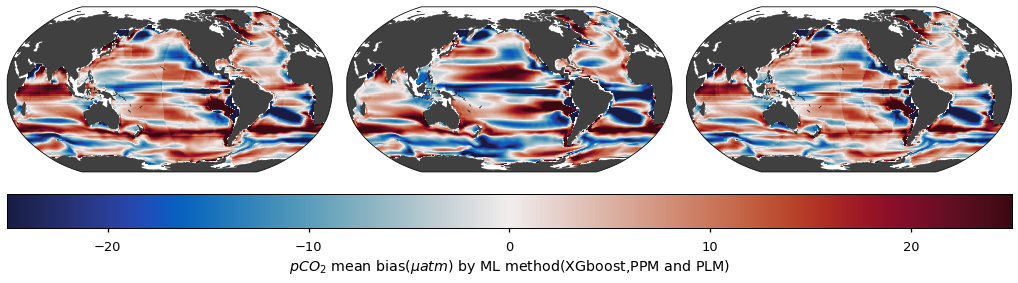

In [ ]:
#@title Bias plot
data_sel = "raw"
metric_sel = "bias_mean"
vrange = [-25, 25, 5]
fig_shape = (1,3)
cmap = cm.cm.balance
lab = '$pCO_2$ mean bias($\mu atm$) by ML method(XGboost,PPM and PLM)'
print(f"{metric_sel} for {data_sel} data by ML method(XGboost,PPM and PLM)")      
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(18,24))

    ### Mask
    dia = SpatialMap(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    
    #for i in range(fig_shape[0]*fig_shape[1]):
    map_sel = map_data[(approach,data_sel,metric_sel)].roll(xlon=-30,roll_coords=True)
    sub = dia.add_plot(lat = map_sel['ylat'],
                       lon = map_sel['xlon'], 
                       data = map_sel.T, 
                       vrange=vrange[0:2], 
                       cmap=cmap,
                       ax = 0)
#         dia.set_title(approaches_labs[i], i, loc="left")
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, lab);
     
      
    ### Mask

    map_sel_ppm = map_data_ppm[(approach2,data_sel,metric_sel)].roll(xlon=-30,roll_coords=True)
    sub2 = dia.add_plot(lat = map_sel_ppm['ylat'],                    
                       lon = map_sel_ppm['xlon'], 
                       data = map_sel_ppm.T, 
                       vrange=vrange[0:2], 
                       cmap=cmap,
                       ax = 1)
    col = dia.add_colorbar(sub2)
    dia.set_cbar_xlabel(col, lab);
 
    map_sel_pl = map_data_pl[(approach3,data_sel,metric_sel)].roll(xlon=-30,roll_coords=True)
    sub2 = dia.add_plot(lat = map_sel_pl['ylat'],                    
                       lon = map_sel_pl['xlon'], 
                       data = map_sel_pl.T, 
                       vrange=vrange[0:2], 
                       cmap=cmap,
                       ax = 2)
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, lab);

### How good is the phasing of the seasonal cycle? Presented as correlation between the reconstruction and the original ESM pCO$_2$? 

corr_mean for ['seasonal'] data by ML method(XGboost,PPM and PLM)


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

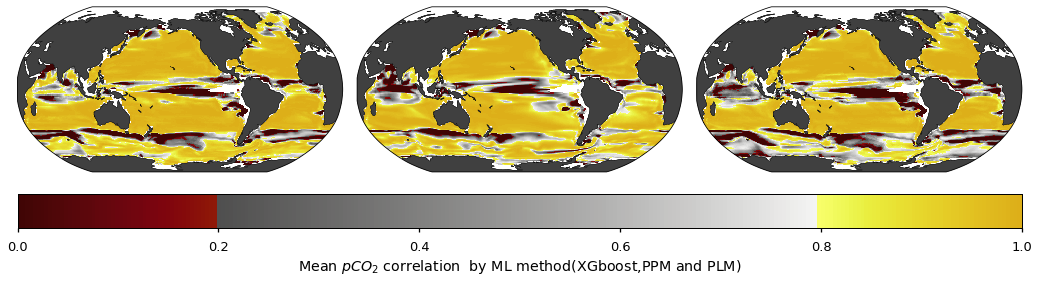

In [ ]:
# @title Correlation Plot
data_sel = ["seasonal"]
metric_sel = "corr_mean"
vrange = [0, 1, .01]
fig_shape = (1,3)
cmap = cm.cm.oxy
lab = 'Mean $pCO_2$ correlation  by ML method(XGboost,PPM and PLM)'
print(f"{metric_sel} for {data_sel} data by ML method(XGboost,PPM and PLM)")      
  
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(18,24))
    dia = SpatialMap(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    
    for i in range(fig_shape[0]*fig_shape[1]):
        map_sel = map_data[(approach,data_sel[0],metric_sel)].roll(xlon=-30,roll_coords=True)
        sub = dia.add_plot(lat = map_sel['ylat'], 
                           lon = map_sel['xlon'], 
                           data = map_sel.T, 
                           vrange=vrange[0:2], 
                           cmap=cmap, 
                           ax=0)
    col = dia.add_colorbar(sub)
  

    for i in range(fig_shape[0]*fig_shape[1]):
        map_sel = map_data_ppm[(approach2,data_sel[0],metric_sel)].roll(xlon=-30,roll_coords=True)
        sub = dia.add_plot(lat = map_sel['ylat'], 
                           lon = map_sel['xlon'], 
                           data = map_sel.T, 
                           vrange=vrange[0:2], 
                           cmap=cmap, 
                           ax=1)
    col = dia.add_colorbar(sub)
  

    for i in range(fig_shape[0]*fig_shape[1]):
        map_sel_pl = map_data_pl[(approach3,data_sel[0],metric_sel)].roll(xlon=-30,roll_coords=True)
        sub = dia.add_plot(lat = map_sel_pl['ylat'], 
                           lon = map_sel_pl['xlon'], 
                           data = map_sel_pl.T, 
                           vrange=vrange[0:2], 
                           cmap=cmap, 
                           ax=2)
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, lab)

### How good is the amplitude of the seasonal cycle at each point? Calculated as a %error?

amp_%error for ['seasonal'] data ML


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

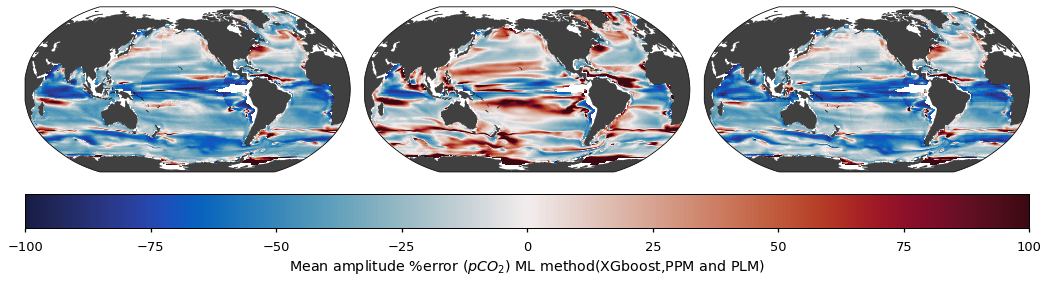

In [ ]:
# @title Mean amplitude plot of XGBoost
data_sel = ["seasonal"]
metric_sel = "amp_%error"
vrange = [-100, 100, 1]
fig_shape = (1,3)
cmap = cm.cm.balance
lab = 'Mean amplitude %error ($pCO_2$) ML method(XGboost,PPM and PLM)'

print(f"{metric_sel} for {data_sel} data ML")      
      
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(18,24))
    dia = SpatialMap(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    map_sel = map_data[(approach,data_sel[0],metric_sel)].roll(xlon=-30,roll_coords=True)
    sub = dia.add_plot(lat = map_sel['ylat'], 
                       lon = map_sel['xlon'], 
                       data = map_sel.T*100, 
                       vrange=vrange[0:2], 
                       cmap=cmap, 
                       ax=0)
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, lab)
    map_sel_ppm = map_data_ppm[(approach2,data_sel[0],metric_sel)].roll(xlon=-30,roll_coords=True)
    sub = dia.add_plot(lat = map_sel_ppm['ylat'], 
                       lon = map_sel_ppm['xlon'], 
                       data = map_sel_ppm.T*100, 
                       vrange=vrange[0:2], 
                       cmap=cmap, 
                       ax=1)
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, lab)

    map_sel_pl = map_data_pl[(approach3,data_sel[0],metric_sel)].roll(xlon=-30,roll_coords=True)
    sub3 = dia.add_plot(lat = map_sel_pl['ylat'], 
                       lon = map_sel_pl['xlon'], 
                       data = map_sel_pl.T*100, 
                       vrange=vrange[0:2], 
                       cmap=cmap, 
                       ax=2)
    col = dia.add_colorbar(sub3)
    dia.set_cbar_xlabel(col, lab)

## Discussion

**Error Metrics (MSE & MAE & Correlation) on (Test & Unseen Data)**

1.   Partial Linear Model
2.   XGBoost
3.   Projection Pursuit


The Projection Pursuit model is the most complicated model we tested as it is essence performing non-linear transformations of the linear combination of features similar to a Neural Network structure: where each combination of input features are estimated one at a time and then updated with the weights. However, because the PPM algorithm keeps fitting to the residual of the data, it is prone to overfitting which explains why its error (MSE & MAE) was the highest of the three models. While XGBoost is a fully non-parametric model, the Partial Linear Model is the best of both worlds; it takes advantage of the features that are linearly correlated with pCO2 and then uses XGBoost for the non-parametric portion to capture the trend of true model, which is why its error (MSE & MAE) was the lowest and the overall Correlation was the highest.


**Mean pCO2 Correlation consistency in southern ocean (Test & Unseen)**

1.   Projection Pursuit 
2.   XGBoost
3.   Partial Linear 

Although the Partial Linear model has the best overall correlation, when checking the correlation map, there are some important differences. We have three distinct colors in the colormap; Red, Grey and Yellow. When the correlation is about 0.8 there is a big chance that the correlation for PLM is about 0.79 and the correlation for PPM is 0.82 but that leads to a different color in the plots but only results in a slight difference in overall correlation.
But we still get some useful information here, Projection Pursuit has a good performance on correlation consistency indicated by the correlation plot.

Semi-parametric models perform better on sparse data like in the Southern Ocean compared to non-parametric models. Interestingly, both semi-parametric methods have a  relatively lower correlation in the Indian ocean. Here, the Projection Pursuit model uses univariate regression functions instead of their multivariate form combined with its similar structure to a Neural Network might leads to more consistent performance in correlation map.




**Partial Linear Model**

When testing the Partial Linear Model, we tried different combinations of the 13 features for the linear portion. However, we found that only when [xCO2, T0, T1] are used in the linear part, the MAE/MSE has the best performance. However, when using other variables like SSS, A, B, C, location related variables, which seemed random in the residual plots into the linear componenet, these combinations all performed worse in MAE/MSE for test and unseen data. Thus, we were able to successfully isolate the features **[xCO2, T0, T1]** as the features that have a strong linear relationship with pCO2 while the others need XGBoost to develop the non-parametric part.

This result makes sense because xCO2(atmospheric CO2 mixing ratio) is the ratio of CO2 in the atmosphere, when it increases, partial pressure in the atmosphere (pCO2 atm) increases. Since the CO2 absorbed by the ocean is highly correlated with CO2 in the atmosphere, the surface ocean partial pressure of CO2 will increase correspondingly. T0, T1 are time parameters, and the pCO2 increases with time which also makes sense from the science. And with this simple relationship, a partially linear model helps our ML method better capture the trend of the true model and increases the accuracy of the test.

## Conclusion

### Recap

**RNN/CNN** - Overall, we did not see significant differences in the performances of the RNN and CNN-autoencoder models with the baseline XGBoost model. This result suggests that global features are of little importance in the reconstruction of pCO2 when compared with local processes, but this limitation could be due to the sparsity of the SOCAT dataset that the model is trained on. 


**Projection Pursuit/Partial Linear Models** - The Partial Linear model performed best on MSE/MAE and Correlation on test and useen data while the Projection Pursuit Model performed best in pCO2 correlation consistency in the southern ocean.


### Future Work

**Tuning Hyperparameters** - We did not perform hyperparameter tuning for all the models tested; the performance improvements seen might come from hyperparameter tuning rather than underlying statistical relationships.

**Alternate Models**
1.   ConvLSTM model could be tested as another method to extract spatio-temporal relationships of the features.
2.   Implement XGBoost as the non-parametric part to the Projection Pursuit model instead of the standard Spline/Kernel regression. The Partial Linear model we ran used XGBoost as the non-parametric part which produced better results on MSE/MAE. However, when implementing spline instead as the non-parametric part to the Partial Linear model, we noticed a far worse result in MSE/MAE so the choice of the non-parametric function plays an important role is the performance.

**Datasets with Finer Spatial Resolution** - The dataset we use has a coarse spatial (1-degree x 1-degree) resolution, therefore it is possible that many spatio-temporal relationships cannot be captured at this existing resolution. However there are versions at ESMs that run at finer spatial resolution—SST would be comparatively less varying in the middle of the ocean basin, but more variable in the near coastal region. Currently these areas are mostly masked off, but with finer resolution data we might not only improve reconstruction but also output pCO2 maps with finer spatial resolution.

# Reference

+ Gloege, L., McKinley, G. A., Landschützer, P., Fay, A. R., Frölicher, T. L., Fyfe, J. C., et al. (2021). Quantifying errors in observationally based estimates of ocean carbon sink variability. Global Biogeochemical Cycles, 35, e2020GB006788. https://doi.org/10.1029/2020GB006788

+ Gloege, L., Yan, M., Zheng, T., & McKinley, G. A. (2022). Improved quantification of ocean carbon uptake by using machine learning to merge global models and pCO2 data. Journal of Advances in Modeling Earth Systems, 14, e2021MS002620. https://doi.org/10.1029/2021MS002620
